In [1]:
!pwd
#!ls ./ -al
print()
!ls /kaggle/input/ids-intrusion-csv -al
!ls ./ -al

/kaggle/working

total 6725268
drwxr-xr-x 2 nobody nogroup          0 Feb 20 02:44 .
drwxr-xr-x 3 root   root          4096 Mar 30 20:16 ..
-rw-r--r-- 1 nobody nogroup  358223333 Feb 20 02:45 02-14-2018.csv
-rw-r--r-- 1 nobody nogroup  375945899 Feb 20 02:45 02-15-2018.csv
-rw-r--r-- 1 nobody nogroup  333723605 Feb 20 02:45 02-16-2018.csv
-rw-r--r-- 1 nobody nogroup 4054925350 Feb 20 02:47 02-20-2018.csv
-rw-r--r-- 1 nobody nogroup  328893673 Feb 20 02:45 02-21-2018.csv
-rw-r--r-- 1 nobody nogroup  382636202 Feb 20 02:45 02-22-2018.csv
-rw-r--r-- 1 nobody nogroup  382840456 Feb 20 02:45 02-23-2018.csv
-rw-r--r-- 1 nobody nogroup  209249758 Feb 20 02:45 02-28-2018.csv
-rw-r--r-- 1 nobody nogroup  107842858 Feb 20 02:44 03-01-2018.csv
-rw-r--r-- 1 nobody nogroup  352368373 Feb 20 02:45 03-02-2018.csv
total 67140
drwxr-xr-x 3 root root     4096 Mar 30 20:16 .
drwxr-xr-x 5 root root     4096 Mar 30 20:16 ..
drwxr-xr-x 2 root root     4096 Mar 30 20:16 .virtual_documents
---------- 1 root r

In [2]:
# U Must Run this cell
#https://arxiv.org/pdf/1807.01069.pdf
#https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/examples/README.md
!pip install -U adversarial-robustness-toolbox
import tensorflow as tf
if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')
import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.disable_eager_execution()
import numpy as np
from matplotlib import pyplot as plt

from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod
from art.estimators.classification import KerasClassifier,TensorFlowV2Classifier


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 40.1 MB/s eta 0:00:0000:01


# Load and concat

In [3]:
inpDir="/kaggle/input/ids-intrusion-csv/"
inpFiles=['02-14-2018.csv','02-15-2018.csv']

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report
from sklearn.svm import OneClassSVM

Frames=[]
for fn in inpFiles:
    dfTemp=pd.read_csv(inpDir+fn)
    print(" Downlading {} shape:{}".format(fn,dfTemp.shape))
    Frames.append(dfTemp)
if len(inpFiles)>1: originalDF = pd.concat(Frames);del dfTemp
else: originalDF=dfTemp

print('Final shape:',originalDF.shape)
#originalDF
print(originalDF.describe(include = 'object'))
originalDF.describe(include = 'all')

 Downlading 02-14-2018.csv shape:(1048575, 80)
 Downlading 02-15-2018.csv shape:(1048575, 80)
Final shape: (2097150, 80)
                  Timestamp    Label
count               2097150  2097150
unique                65905        5
top     15/02/2018 09:53:24   Benign
freq                    728  1663703


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,2.097150e+06,2.097150e+06,2097150,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,...,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2097150
unique,NaN,NaN,65905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,15/02/2018 09:53:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Benign
freq,NaN,NaN,728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1663703
mean,6.134380e+03,8.813011e+00,NaN,1.028147e+07,5.676310e+00,6.815488e+00,4.417099e+02,4.723844e+03,1.630066e+02,1.118473e+01,...,1.993505e+01,8.188203e+04,3.486536e+04,1.348432e+05,6.158000e+04,3.724341e+06,4.977859e+05,4.714533e+06,3.118095e+06,NaN
std,1.611496e+04,4.950855e+00,NaN,8.914813e+08,3.950497e+01,1.014267e+02,2.321434e+04,1.458393e+05,2.828337e+02,2.194242e+01,...,1.001594e+01,7.855725e+05,3.086169e+05,1.000943e+06,7.307746e+05,3.830152e+08,2.701221e+08,1.076350e+09,1.624343e+07,NaN
min,0.000000e+00,0.000000e+00,NaN,-9.190110e+11,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN
25%,5.300000e+01,6.000000e+00,NaN,1.080000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN
50%,8.000000e+01,6.000000e+00,NaN,3.907000e+03,2.000000e+00,1.000000e+00,4.100000e+01,7.400000e+01,3.900000e+01,0.000000e+00,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN
75%,4.450000e+02,1.700000e+01,NaN,1.783384e+06,6.000000e+00,4.000000e+00,3.640000e+02,4.880000e+02,1.610000e+02,3.000000e+01,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN


# Separate Nominal/Quantitative

In [5]:
MAX_CATEGORICAL=20
Columns=originalDF.columns
Attributes={}
typos={'float64':'numeric','int64':'numeric','object':'string'}
for col in Columns:
    st=""
    nulls=False;infs=False;meaningless=False;values=set([])
    typo=str(originalDF.dtypes[col]);myTypo=typos[typo]
    if originalDF[col].isnull().sum()>0: 
        nulls=True;meaningless=True;st+='\tContains '+str(originalDF[col].isnull().sum())+' Nulls\n'
    if myTypo=='numeric':
        if np.isinf(originalDF[col]).sum()>0: 
            infs=True;meaningless=True; st+="\tColumn contains Inf's\n"
        vals=set(originalDF[col].unique())
        if len(vals) <= MAX_CATEGORICAL: 
            values=vals
            myTypo='string' 
    if myTypo=='string':
        vals=set(originalDF[col].unique())
        if len(vals) ==1: meaningless=True;st+='\tSingle Value Column\n'
        elif len(vals)>MAX_CATEGORICAL: meaningless=True;st+='\tToo Many values for a categorical\n'
        else: values=vals
    if meaningless: values=st
    meta=[myTypo,meaningless,[nulls,infs,values]]
    Attributes[col]=meta
    if meta[1]:
        print('>>> Recommended to drop Feature: ',col)
        print(meta[2][2])
    else:
        if meta[0]=='numeric': print (col,meta[0])
        else: print (col,meta[0],meta[2][2])

Dst Port numeric
Protocol string {0, 17, 6}
>>> Recommended to drop Feature:  Timestamp
	Too Many values for a categorical

Flow Duration numeric
Tot Fwd Pkts numeric
Tot Bwd Pkts numeric
TotLen Fwd Pkts numeric
TotLen Bwd Pkts numeric
Fwd Pkt Len Max numeric
Fwd Pkt Len Min numeric
Fwd Pkt Len Mean numeric
Fwd Pkt Len Std numeric
Bwd Pkt Len Max numeric
Bwd Pkt Len Min numeric
Bwd Pkt Len Mean numeric
Bwd Pkt Len Std numeric
>>> Recommended to drop Feature:  Flow Byts/s
	Contains 7198 Nulls
	Column contains Inf's

>>> Recommended to drop Feature:  Flow Pkts/s
	Column contains Inf's

Flow IAT Mean numeric
Flow IAT Std numeric
Flow IAT Max numeric
Flow IAT Min numeric
Fwd IAT Tot numeric
Fwd IAT Mean numeric
Fwd IAT Std numeric
Fwd IAT Max numeric
Fwd IAT Min numeric
Bwd IAT Tot numeric
Bwd IAT Mean numeric
Bwd IAT Std numeric
Bwd IAT Max numeric
Bwd IAT Min numeric
Fwd PSH Flags string {0, 1}
>>> Recommended to drop Feature:  Bwd PSH Flags
	Single Value Column

>>> Recommended to drop 

# Column Dictionary colDict

In [6]:
for col in Columns:
    meta=Attributes[col]
    if meta[0] =='string' and meta[2][2]=={0,1}  : Attributes[col][0]='bin'
for col in Columns:
    meta=Attributes[col]
    if meta[0] =='bin': print (col,meta)
    
    

Fwd PSH Flags ['bin', False, [False, False, {0, 1}]]
FIN Flag Cnt ['bin', False, [False, False, {0, 1}]]
SYN Flag Cnt ['bin', False, [False, False, {0, 1}]]
RST Flag Cnt ['bin', False, [False, False, {0, 1}]]
PSH Flag Cnt ['bin', False, [False, False, {0, 1}]]
ACK Flag Cnt ['bin', False, [False, False, {0, 1}]]
URG Flag Cnt ['bin', False, [False, False, {0, 1}]]
ECE Flag Cnt ['bin', False, [False, False, {0, 1}]]


In [7]:

ColDict = {"categorical":[],
           "continuous":[],
           "Binary":[],
           "meaningless":[]}
for col in Columns:
    meta=Attributes[col]
    if meta[1]:ColDict['meaningless'].append(col)
    elif meta[0]=='numeric': ColDict['continuous'].append(col)
    elif meta[0]=='bin': ColDict['Binary'].append(col)
    elif meta[0]=='string': ColDict['categorical'].append(col)
    else: print('Error');break
for el in ColDict: print(el,ColDict[el],"\n")
droplist=ColDict["meaningless"]
print('droplist:')
droplist

categorical ['Protocol', 'Fwd Seg Size Min', 'Label'] 

continuous ['Dst Port', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min'] 

['Timestamp',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'CWE Flag Count',
 'Fwd Byts/b Avg',
 'Fwd Pkts/b Avg',
 'Fwd Blk Rate Avg',
 'Bwd Byts/b Avg',
 'Bwd Pkts/b Avg',
 'Bwd Blk Rate Avg']

# Cleansing
## Ex if you want to remove from from list 'Timestamp': dropList.remove('Timestamp')

In [8]:
# droplist.remove('Timestamp')
df=originalDF.copy()
for atr in ColDict['meaningless']:
    if atr in Columns:
        df.drop(atr,axis=1,inplace=True)
        print('Attribute',atr,"Dropped")
    else: print('Attribute',atr,"Already Dropped")
print('Original Shape:',originalDF.shape)
print('Shape after Cleaning',df.shape)
ClassName='Label'

Attribute Timestamp Dropped
Attribute Flow Byts/s Dropped
Attribute Flow Pkts/s Dropped
Attribute Bwd PSH Flags Dropped
Attribute Fwd URG Flags Dropped
Attribute Bwd URG Flags Dropped
Attribute CWE Flag Count Dropped
Attribute Fwd Byts/b Avg Dropped
Attribute Fwd Pkts/b Avg Dropped
Attribute Fwd Blk Rate Avg Dropped
Attribute Bwd Byts/b Avg Dropped
Attribute Bwd Pkts/b Avg Dropped
Attribute Bwd Blk Rate Avg Dropped
Original Shape: (2097150, 80)
Shape after Cleaning (2097150, 67)


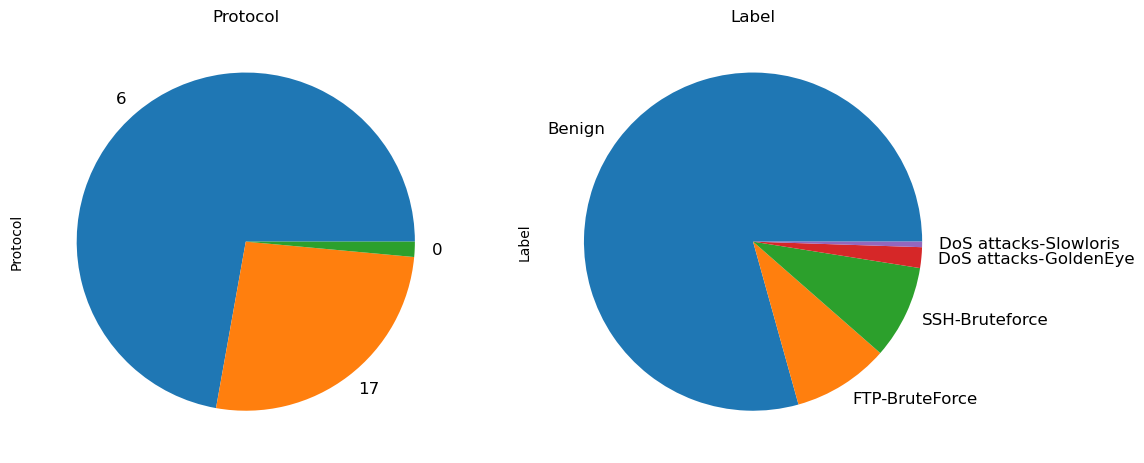

In [9]:
import matplotlib.pyplot as plt
def pie_plot(df, cols_list, rows):
    cols=len(cols_list)
    fig, axes = plt.subplots(rows, cols,figsize=(12,8))
    for ax, col in zip(axes.ravel(), cols_list):
        df[col].value_counts().plot.pie(fontsize=12,ax=ax )
        ax.set_title(str(col), fontsize = 12)
    plt.show()
pie_plot(df, ['Protocol', 'Label'], 1)

--------

# <span style="color:red"> one hot key mapping

In [10]:
dictCop=ColDict.copy()
dfCop=df.copy()

rep={'Benign':0, 'FTP-BruteForce':1, 'SSH-Bruteforce':1,
       'DoS attacks-GoldenEye':1, 'DoS attacks-Slowloris':1, 'Bot':1}
dfCop["Label"] =dfCop["Label"].map(lambda x: rep[x] if x in rep else x)

#dfLabel=dfCop['Label']
catList=dictCop['categorical']
binList=dictCop['Binary'].copy()


for col in catList[0:-1]:
    df_onehot = pd.get_dummies(dfCop[col],col)
    for nCol in df_onehot.columns:
        dfCop[nCol]=df_onehot[nCol]
        binList.append(nCol)
    dfCop.drop(columns=[col],inplace=True)
#dfCop.drop('Label')
#y = dfNorm["Label"]

#dfCop.drop(columns=['Label'],inplace=True)
binList.append('Label')
dictCop['Binary']=binList

print(dfCop.columns,dfCop.shape)

Index(['Dst Port', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s',
       'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std',
       'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt',
       'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'ECE Flag Cnt',
       'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
       'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts',
       'Subflow Bwd Byts', 'In

# Some Visualization & Feature Management

# Categorical

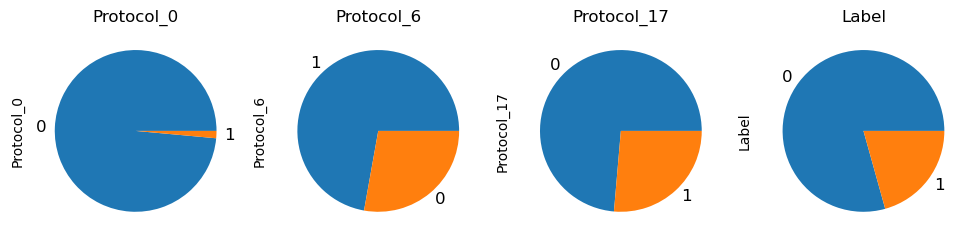

In [11]:
pie_plot(dfCop, ['Protocol_0', 'Protocol_6','Protocol_17','Label'], 1)


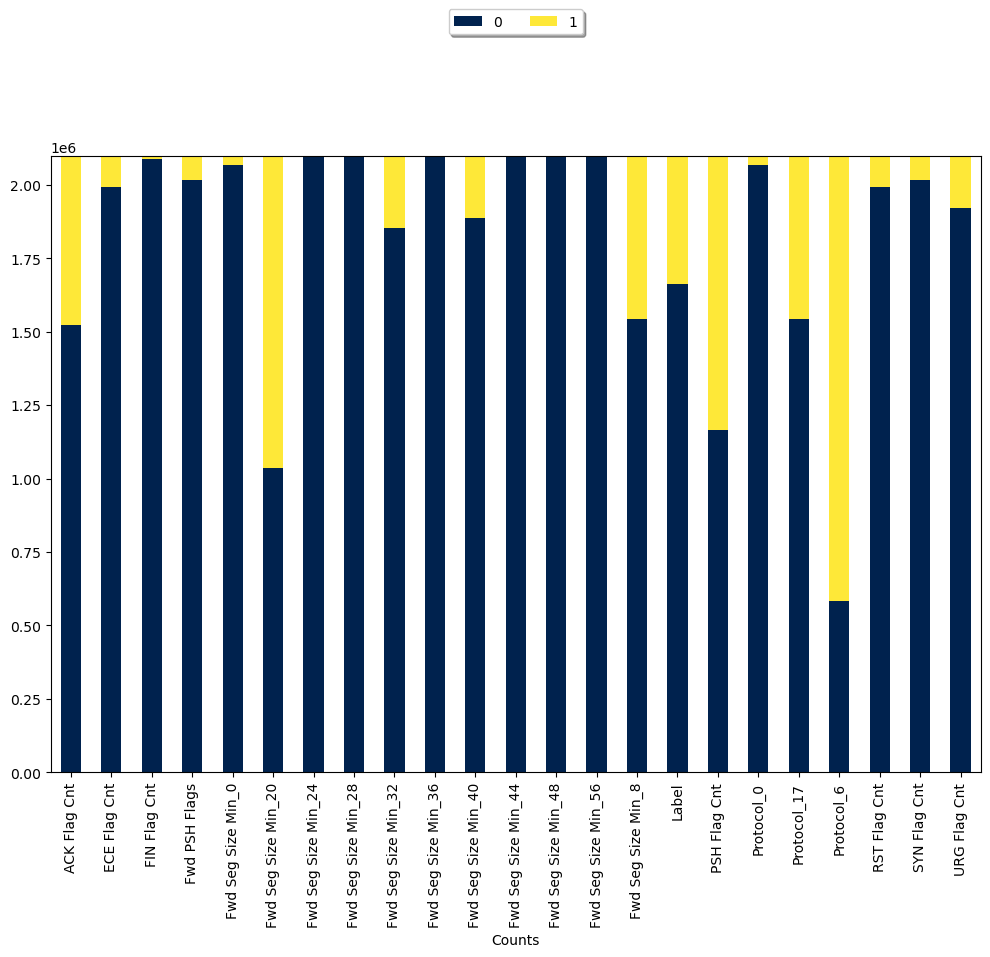

['Fwd PSH Flags',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'ECE Flag Cnt',
 'Protocol_0',
 'Protocol_6',
 'Protocol_17',
 'Fwd Seg Size Min_0',
 'Fwd Seg Size Min_8',
 'Fwd Seg Size Min_20',
 'Fwd Seg Size Min_24',
 'Fwd Seg Size Min_28',
 'Fwd Seg Size Min_32',
 'Fwd Seg Size Min_36',
 'Fwd Seg Size Min_40',
 'Fwd Seg Size Min_44',
 'Fwd Seg Size Min_48',
 'Fwd Seg Size Min_56',
 'Label']

In [12]:

def plotCategList(df,lst):
    dfx=df[lst]
    dfmelted = dfx.melt()
    ctab = pd.crosstab(index=dfmelted['variable'], columns=dfmelted['value'])
    ctab.plot.bar(figsize=(12,8), xlabel='Counts',stacked=True,cmap='cividis');
    #plt.gca().set_yscale('log')
    #plt.gca().legend()
    plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
              ncol=3, fancybox=True, shadow=True)
    plt.show()
#plotCategList(dfCop,dictCop['Binary'][0:6])
plotCategList(dfCop,dictCop['Binary'])
dictCop['Binary']

# Numerical (Quantitative, continuous)

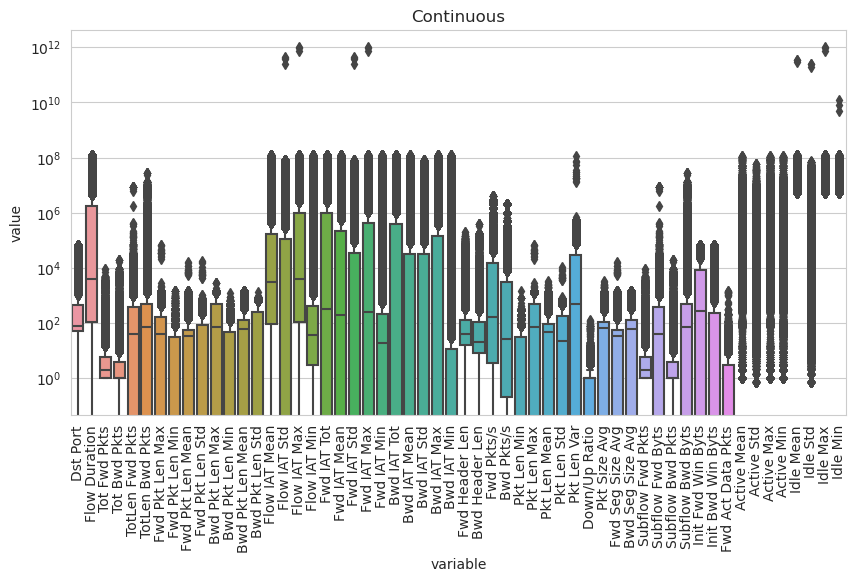

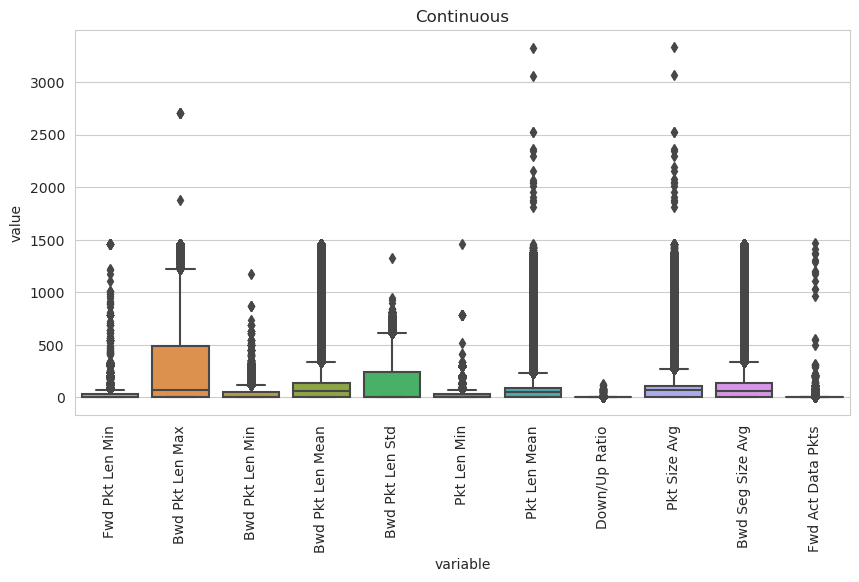

In [13]:
import seaborn as sns

def plotContinous(df,lst,log=True,title='Continuous'):
    dfx=df[lst]
    plt.figure(figsize=(10,5))
    sns.set_style("whitegrid")
    sns.boxplot(x="variable", y="value", data=pd.melt(dfx))
    index = np.arange(len(dfx.columns))
    plt.xticks(index, dfx.columns, rotation=90)
    if log: plt.gca().set_yscale('log')
    plt.title(title)
    plt.show()
plotContinous(dfCop,dictCop['continuous'])  
# select some with closesr values
lst=[]
for col in dictCop['continuous']:
    if df[col].min()>=0.0 and df[col].max()<4000.0:
        lst.append(col)
plotContinous(dfCop,lst,log=False) 

# Outliers

In [14]:
def numberOut(data,threshold = 3):
    mean = np.mean(data)
    std_dev = np.std(data)
    #More than 3 standard deviations from the mean an outlier
    #create the condition to find outliers
    outliers = data[np.abs(data - mean) > threshold * std_dev]
    return outliers.shape[0]
from scipy import stats
for col in dictCop['continuous']:
    _,p=stats.normaltest(dfCop[col])
    print('{:20} #outliers={:6}   p={}'.format(col,numberOut(dfCop[col]),p))


Dst Port             #outliers= 29962   p=0.0
Flow Duration        #outliers=     5   p=0.0
Tot Fwd Pkts         #outliers=  2807   p=0.0
Tot Bwd Pkts         #outliers=  2703   p=0.0
TotLen Fwd Pkts      #outliers=    41   p=0.0
TotLen Bwd Pkts      #outliers=  2513   p=0.0
Fwd Pkt Len Max      #outliers= 16684   p=0.0
Fwd Pkt Len Min      #outliers=  8044   p=0.0
Fwd Pkt Len Mean     #outliers= 16199   p=0.0
Fwd Pkt Len Std      #outliers= 20463   p=0.0
Bwd Pkt Len Max      #outliers=     7   p=0.0
Bwd Pkt Len Min      #outliers= 32835   p=0.0
Bwd Pkt Len Mean     #outliers= 53129   p=0.0
Bwd Pkt Len Std      #outliers= 10280   p=0.0
Flow IAT Mean        #outliers=     5   p=0.0
Flow IAT Std         #outliers=     4   p=0.0
Flow IAT Max         #outliers=     5   p=0.0
Flow IAT Min         #outliers=     5   p=0.0
Fwd IAT Tot          #outliers=     5   p=0.0
Fwd IAT Mean         #outliers=     5   p=0.0
Fwd IAT Std          #outliers=     4   p=0.0
Fwd IAT Max          #outliers=   

# <span style="color:red"> Normalisation & Standardisation

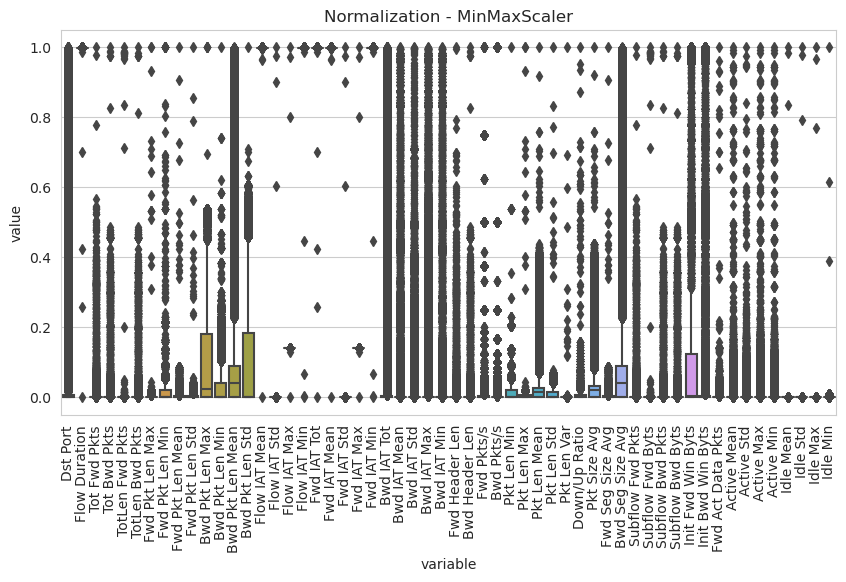

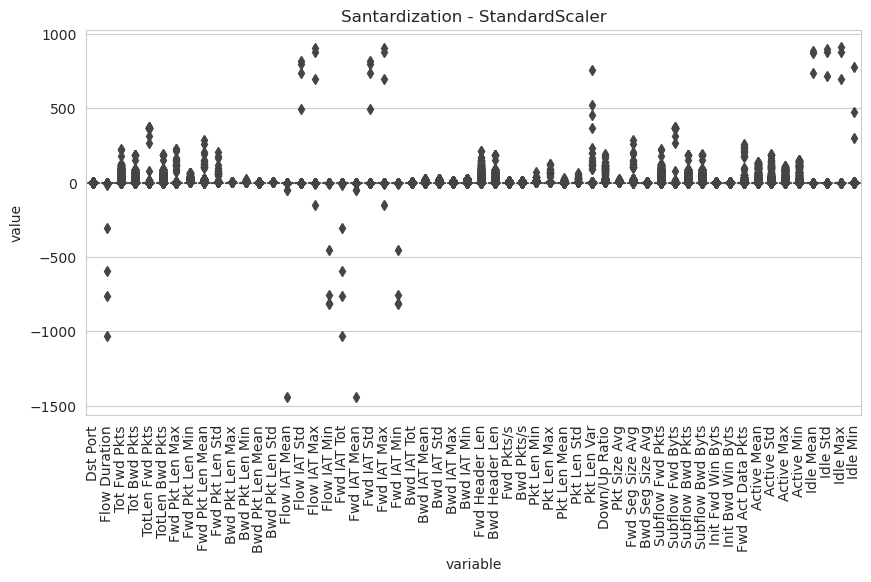

Contious Features: (2097150, 56)


In [15]:
from sklearn import preprocessing
dfx2 = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(dfCop[dictCop['continuous']]))
dfx2.columns=dictCop['continuous']
plotContinous(dfx2,dictCop['continuous'],log=False,title='Normalization - MinMaxScaler')

dfx2 = pd.DataFrame(preprocessing.StandardScaler().fit_transform(dfCop[dictCop['continuous']]))
dfx2.columns=dictCop['continuous']
plotContinous(dfx2,dictCop['continuous'],log=False,title='Santardization - StandardScaler')
print('Contious Features:',dfx2.shape)

In [16]:
dfCop

,Dst Port,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,...,Fwd Seg Size Min_8,Fwd Seg Size Min_20,Fwd Seg Size Min_24,Fwd Seg Size Min_28,Fwd Seg Size Min_32,Fwd Seg Size Min_36,Fwd Seg Size Min_40,Fwd Seg Size Min_44,Fwd Seg Size Min_48,Fwd Seg Size Min_56
0,0,112641719,3,0,0,0,0,0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,0,112641466,3,0,0,0,0,0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,0,112638623,3,0,0,0,0,0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,22,6453966,15,10,1239,2273,744,0,82.600000,196.741237,...,0,0,0,0,1,0,0,0,0,0
4,22,8804066,14,11,1143,2209,744,0,81.642857,203.745545,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,50111,22,3,0,31,0,31,0,10.333333,17.897858,...,0,1,0,0,0,0,0,0,0,0
1048571,443,54682783,5,1,123,46,46,0,24.600000,23.276598,...,0,1,0,0,0,0,0,0,0,0
1048572,443,53682093,5,1,123,46,46,0,24.600000,23.276598,...,0,1,0,0,0,0,0,0,0,0
1048573,443,54683364,5,1,123,46,46,0,24.600000,23.276598,...,0,1,0,0,0,0,0,0,0,0


In [17]:
dfCop2=dfCop.copy()
dfCop2[dictCop['continuous']]=dfx2
dfCop2

,Dst Port,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,...,Fwd Seg Size Min_8,Fwd Seg Size Min_20,Fwd Seg Size Min_24,Fwd Seg Size Min_28,Fwd Seg Size Min_32,Fwd Seg Size Min_36,Fwd Seg Size Min_40,Fwd Seg Size Min_44,Fwd Seg Size Min_48,Fwd Seg Size Min_56
0,-0.380664,0.114820,-0.067746,-0.067196,-0.019027,-0.032391,-0.576334,-0.509731,-0.731214,-0.571876,...,0,0,0,0,0,0,0,0,0,0
1,-0.380664,0.114820,-0.067746,-0.067196,-0.019027,-0.032391,-0.576334,-0.509731,-0.731214,-0.571876,...,0,0,0,0,0,0,0,0,0,0
2,-0.380664,0.114817,-0.067746,-0.067196,-0.019027,-0.032391,-0.576334,-0.509731,-0.731214,-0.571876,...,0,0,0,0,0,0,0,0,0,0
3,-0.379299,-0.004293,0.236013,0.031397,0.034345,-0.016805,2.054188,-0.509731,0.715078,1.655838,...,0,0,0,0,1,0,0,0,0,0
4,-0.379299,-0.001657,0.210700,0.041257,0.030209,-0.017244,2.054188,-0.509731,0.698319,1.735148,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,-0.375699,-0.000140,-0.017120,-0.017900,0.027883,-0.019205,1.499091,-0.509731,3.082374,2.822158,...,0,1,0,0,0,0,0,0,0,0
1048571,-0.375699,-0.011533,-0.093059,-0.067196,-0.019027,-0.032391,-0.576334,-0.509731,-0.731214,-0.571876,...,0,1,0,0,0,0,0,0,0,0
1048572,-0.375699,-0.005817,-0.067746,-0.057337,-0.019027,-0.032391,-0.576334,-0.509731,-0.731214,-0.571876,...,0,1,0,0,0,0,0,0,0,0
1048573,-0.375699,-0.005660,-0.067746,-0.057337,-0.019027,-0.032391,-0.576334,-0.509731,-0.731214,-0.571876,...,0,1,0,0,0,0,0,0,0,0


# Correlation

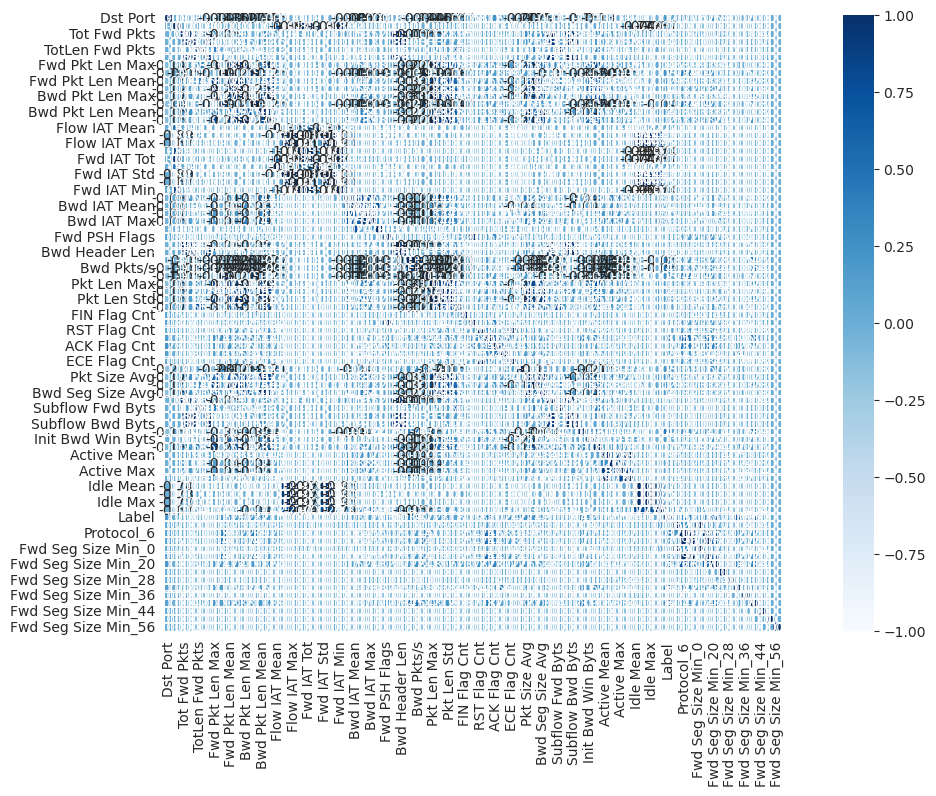

In [18]:
!pip install dython
# Categorical Cramer V
from dython.nominal import associations  
# Step 1: Instantiate a figure and axis object
fig, ax = plt.subplots(figsize=(16, 8))
# Step 2: Creating a pair-wise correlation plot 
# Saving it into a variable(r)
r = associations(dfCop2,nominal_columns=dictCop['Binary'], ax = ax, cmap = "Blues")

# Subset of significant correlations

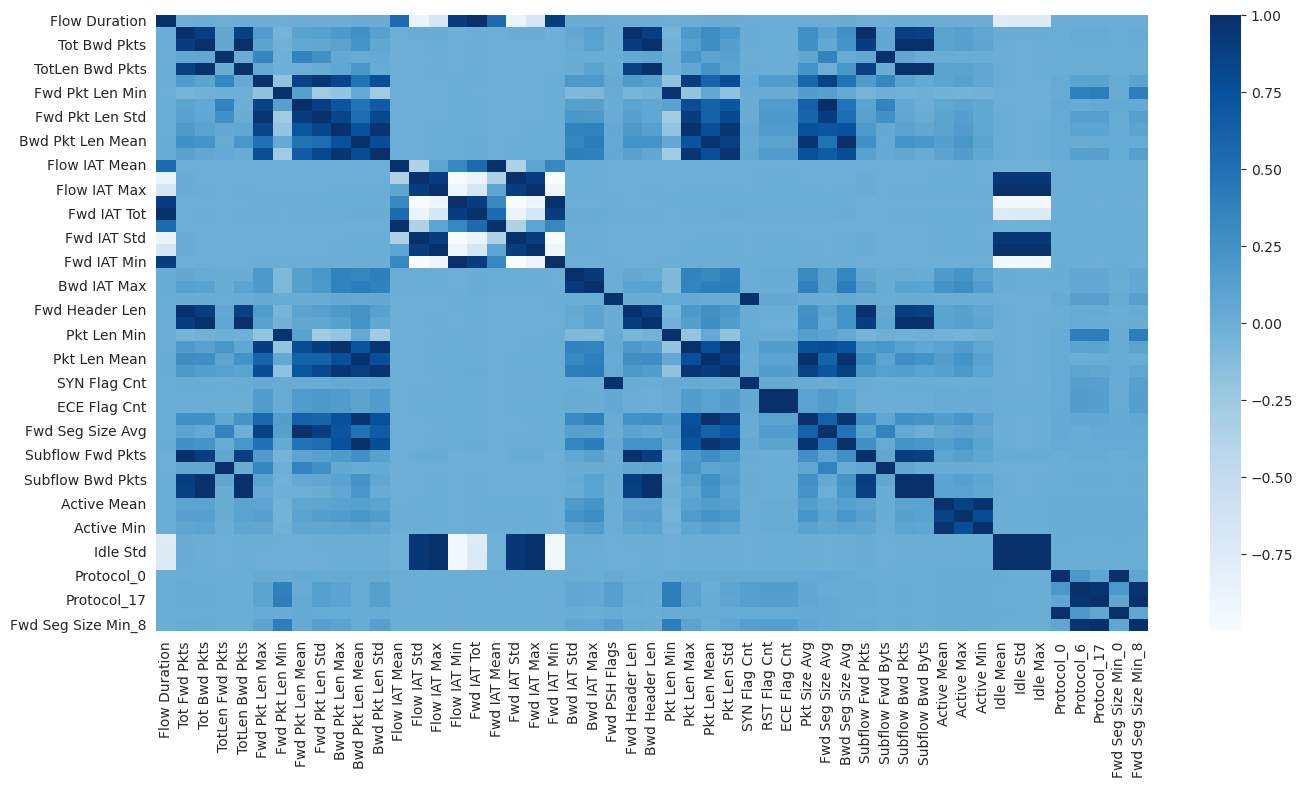

In [19]:
rcor=r['corr']
cols=rcor.columns
count=0;lst=[]
for i in range(len(cols)):
   col=cols[i]
   c=rcor[col]
   for j in range(len(c)):
        x=c[j]
        if abs(x)>.85 and i!=j:
            #print(col,cols[j]);count+=1
            lst.append(col)
            break
rdash=rcor[lst].copy() 
i=len(cols)-1
cols=list(cols)
cols.reverse()
for col in cols:
    if not col in lst:rdash=rdash.drop(rdash.index[i])
    i-=1
import seaborn  
fig, ax = plt.subplots(figsize=(16, 8))
_=seaborn. heatmap (rdash,cmap = "Blues",ax=ax)  

In [20]:
import tensorflow as tf
from tensorflow.keras import regularizers
y=dfCop2['Label']
X = dfCop2[dfCop2.columns.difference(["Label"])]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,shuffle=True) 
x_val = x_train[-100000:]
y_val = y_train[-100000:]
x_train = x_train[:-100000]
y_train = y_train[:-100000]
# sample of 100000 for claical classifiers such as  SVM, logit
x_train_sample=x_train[:100000]
y_train_sample=y_train[:100000]
x_test_sample=x_test[:30000]
y_test_sample=y_train[:30000]


In [21]:
from sklearn import metrics
def eval_classification(model,  X_train, X_test, y_train, y_test,trainset=False):
    if trainset: 
        train_predict=model.predict(X_train)
        train_predict = np.where(train_predict > 0.5, 1.0, 0.0)
        train_cm=metrics.confusion_matrix(y_train,train_predict)
        train_accuracy = metrics.accuracy_score(y_train,train_predict )
        train_precision = metrics.precision_score(y_train,train_predict)
        train_recall = metrics.recall_score(y_train, train_predict)
        train_F1=2*train_precision*train_recall/(train_precision+train_recall)
   
    test_predict=model.predict(X_test)
    test_predict = np.where(test_predict > 0.5, 1.0, 0.0)
    test_cm=metrics.confusion_matrix(y_test, test_predict)
    test_accuracy = metrics.accuracy_score(y_test, test_predict)
    test_precision = metrics.precision_score(y_test, test_predict)
    test_recall = metrics.recall_score(y_test, test_predict)
    test_F1=2*test_precision*test_recall/(test_precision+test_recall)
    if not trainset: return test_cm,test_accuracy,test_precision,test_recall,test_F1
    return train_cm,test_cm,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_F1,test_F1
def pltROC(clfName,x_test,y_test):
    fpr, tpr, _ = metrics.roc_curve(y_test,  rf.predict_proba(x_test)[:,1])
    #create ROC curve
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate') 
    plt.title('AUC ROC Curve :{}'.format(clfName))
    
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)
    
    plt.figure(figsize=(10,10))
    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importances for Decision Tree')
    plt.show()
    names=list(names)
    names.reverse()
    return names
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    ev=eval_classification(model, X_train, X_test, y_train, y_test,trainset=True)
    train_cm,test_cm,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_F1,test_F1=ev
    print("{:20}:Training Accuracy= {:.3f} , Test Accuracy ={:.3f}".format(name,train_accuracy*100,test_accuracy*100))
    print("{:20}:Training Precision={:.3f} , Test Precision={:.3f}".format(name,train_precision*100,test_precision*100))
    print("{:20}:Training Recall=   {:.3f} , Test Recall   ={:.3f}".format(name,train_recall*100,test_recall*100))
    print("{:20}:Training F1    =   {:.3f} , Test F1       ={:.3f}".format(name,train_F1*100,test_F1*100))
    return ev

In [22]:
def plotHistory(history,cols=3,figsize=(10,9)):
  # list all data in history
  lstHist=[['loss','val_loss'], ['accuracy','val_accuracy'] ]
  #global lstHist
  N=len(lstHist)
  rows=int(round((N+0.5)/cols,0))
  #print(history.history.keys())
  fig, axs = plt.subplots(rows, cols,figsize=figsize, constrained_layout=True)
  axs = axs.flat
  for ax in axs[N:]: ax.remove()
  axs=axs[:N]
  #print(len(axs))
  i=0
  for el in lstHist:
        axs[i].plot(history.history[el[0]])
        axs[i].plot(history.history[el[1]])
        axs[i].set_title('model '+el[0])
        axs[i].set_ylabel(el[0])
        axs[i].set_xlabel('epoch')
        axs[i].legend(['train', 'validation'], loc='upper left')
        #plt.show()
        i+=1
  plt.show()
  return axs
## 

In [23]:
'''
def confMat(test_Y, y_pred,predictions,title=""):
    from sklearn import metrics
    matrix = metrics.confusion_matrix(test_Y, y_pred)
    matrixN = matrix.astype('float') / matrix.sum()
    #sns.heatmap(matrix, square=True, annot=True,
    #            annot_kws={ 'fontsize': 16,'fontweight': 'bold','fontfamily': 'serif'}, cmap='Blues', fmt='d', cbar=False)
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(11, 6))
    mid = (fig.subplotpars.right + fig.subplotpars.left)/2
    ax1=plotMatrix(matrix,ax1)
    ax1.set_xlabel('Predictions', fontsize=18)
    ax1.set_ylabel('Actuals', fontsize=18)
    ax1.set_title('matrix',fontsize=16)
    
    ax2=plotMatrix(matrixN.round(5),ax2)
    ax2.set_xlabel('Predictions', fontsize=18)
    ax2.set_ylabel('Actuals', fontsize=18)
    ax2.set_title('normalized',fontsize=16)
    plt.suptitle(title, fontsize=18,x=mid)
    plt.show()

    st="Accuracy: {}".format(metrics.accuracy_score(test_Y.astype(float), y_pred).round(5))+"\n"
    myText(st)
    plt.show()
'''
def plotMatrix(matrix,ax):
    ax.matshow(matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(x=j, y=i,s=matrix[i, j], va='center', ha='center', size='xx-large')
    return ax

def myText(st):
    left=0
    top = 0
    fig = plt.figure()
    #st=st+"\nxxxx=???"
    ax = fig.add_axes([0, 0, 0,0])

    # axes coordinates: (0, 0) is bottom left and (1, 1) is upper right

    ax.text(left, top, st,
            horizontalalignment='left',
            verticalalignment='top',
            #fontweight ='bold',
            fontsize = 14,
            transform=ax.transAxes)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    
def predict(model, test_X):
    """
    Return confusion matrix between predictions and actual values.
    """
    predictions = model.predict(test_X)
    y_pred_booelan = np.where(predictions > 0.5, 1.0, 0.0)
    return y_pred_booelan,predictions 


In [24]:
def plotConfusion(matrix,matrixN,title,st):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(11, 6))
    mid = (fig.subplotpars.right + fig.subplotpars.left)/2
    ax1=plotMatrix(matrix,ax1)
    ax1.set_xlabel('Prediction', fontsize=18)
    ax1.set_ylabel('Actual', fontsize=18)
    ax1.set_title('matrix',fontsize=16)
    
    ax2=plotMatrix(matrixN.round(5),ax2)
    ax2.set_xlabel('Prediction', fontsize=18)
    ax2.set_ylabel('Actual', fontsize=18)
    ax2.set_title('normalized',fontsize=16)
    plt.suptitle(title, fontsize=18,x=mid)
    plt.show()
    myText(st)
    plt.show()
def predictAndEvaluate(model,X_train, X_test, y_train, y_test,trainset=False):
    ev=eval_classification(model, X_train, X_test, y_train, y_test,trainset=trainset)
    #train_cm,test_cm,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_F1,test_F1=ev
    if len(ev)==5:
        test_cm,test_accuracy,test_precision,test_recall,test_F1=ev
        train=False
    else:
        train_cm,test_cm,train_accuracy,test_accuracy,train_precision,\
                    test_precision,train_recall,test_recall,train_F1,test_F1=ev
        train=True
    frmt="Accuracy= {:.5f}       Precision= {:.5f}       Recall= {:.5f}       F1= {:.5f}"
    
    if train:
        matrix = train_cm
        matrixN = matrix.astype('float') / matrix.sum()
        st=frmt.format(test_accuracy,test_precision,test_recall,test_F1)
        plotConfusion(matrix,matrixN,"Training Set",st)
    
    matrix = test_cm
    matrixN = matrix.astype('float') / matrix.sum()
    st=frmt.format(test_accuracy,test_precision,test_recall,test_F1)
    plotConfusion(matrix,matrixN,"Testing Set",st)
    return ev



# Use Random Forest model to order/reduce features

In [25]:

MMD=None
def modelMeta(modelName,attr,val):
    global MMD
    
    if not modelName in MMD.keys(): MMD[modelName]={}
    #if attr=='model' and attr in MMD[modelName].keys() and MMD[modelName]['model']!=val:
    #    del MMD[modelName]['model']; print('Prev Model Dropped')
    MMD[modelName][attr]=val

def createMMD(modelName,model=None,performance=None,type=None,data=None,\
              description=None,times=None,framework='sklearn'):
    global MMD
    if not MMD:MMD={}
    if modelName in MMD.keys():  print('Prev Model Dropped');del MMD[modelName]
    if model: modelMeta(modelName,'model',model)
    else:     modelMeta(modelName,'model',eval(modelName)) 
    if performance  : modelMeta(modelName,'performance',performance)
    if type         : modelMeta(modelName,'type',type)
    if data         : modelMeta(modelName,'data',data)
    if times        : modelMeta(modelName,'times',times)
    if description  : modelMeta(modelName,'description',description)
    modelMeta(modelName,'framework',framework)

def printMMD():
    global MMS
    for name in MMD.keys():
        print('Model:',name)
        model=MMD[name]
        if 'description'in model.keys(): print('\tDescription:{}'.format(model['description']))
        print("\tFrame Work:",model['framework'])
        if 'data'in model.keys(): print("\tdata shape:",model['data'])
        if 'times'in model.keys(): print("\tFit/TestAll times:",model['times'])
        if 'type'in model.keys(): print("\ttype:",model['type'])
        print("\tFrame Work:",model['framework'])
        if 'performance'in model.keys():
            ev=model['performance']
            if len(ev)==5:
                test_cm,test_accuracy,test_precision,test_recall,test_F1=ev
            else:
                train_cm,test_cm,train_accuracy,test_accuracy,train_precision,\
                    test_precision,train_recall,test_recall,train_F1,test_F1=ev
            print("\tPerformance metrics:")
            print('\t\ttest_accuracy',round(test_accuracy,5))
            print('\t\ttest_precision',round(test_precision,5))
            print('\t\ttest_recall',round(test_recall,5))
            print('\t\ttest_F1',round(test_F1,5))

            if len(ev)>5:
                print()
                print('\t\ttrain_accuracy',round(train_accuracy,5))
                print('\t\ttrain_precision',round(train_precision,5))
                print('\t\ttrain_recall',round(train_recall,5))
                print('\t\ttrain_F1',round(train_F1,5))
        
        
        
#MMD
#MMD['rf']['model'].n_estimators


# <span style="color:red"> -----> Hatlt Cell Continue After

In [26]:
raise KeyboardInterrupt

KeyboardInterrupt: 

RandomForestClassifier:Training Accuracy= 99.962 , Test Accuracy =99.934
RandomForestClassifier:Training Precision=99.831 , Test Precision=99.733
RandomForestClassifier:Training Recall=   99.985 , Test Recall   =99.948
RandomForestClassifier:Training F1    =   99.908 , Test F1       =99.841


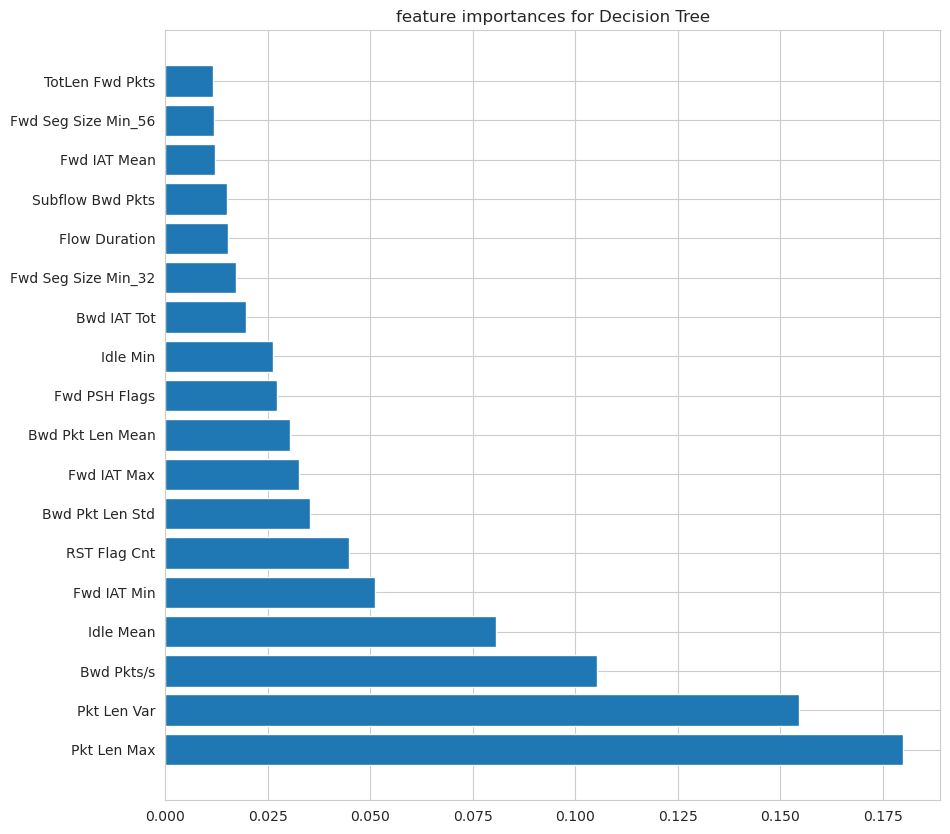

Model: rf
	Description:Radom Forest
	Frame Work: sklearn
	data shape: (100000, 78)
	Fit/TestAll times: [8.128280878067017, 5.894650220870972]
	type: Random Forest Classifier
	Frame Work: sklearn
	Performance metrics:
		test_accuracy 0.99934
		test_precision 0.99733
		test_recall 0.99948
		test_F1 0.99841

		train_accuracy 0.99962
		train_precision 0.99831
		train_recall 0.99985
		train_F1 0.99908


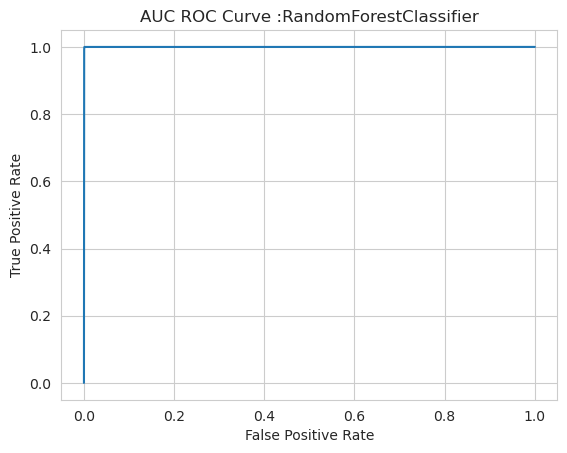

In [27]:
import time    

from sklearn.ensemble import RandomForestClassifier
start_time = time.time() ##################
rf = RandomForestClassifier().fit(x_train_sample,y_train_sample)
train_time=time.time()-start_time   ##################
start_time = time.time() ##################
ev=evaluate_classification(rf, "RandomForestClassifier", x_train_sample, x_test, y_train_sample, y_test)
test_all_time=time.time() - start_time  ##################
orderedNames=f_importances(abs(rf.feature_importances_), cols, top=18)
pltROC('RandomForestClassifier',x_test,y_test)

description='Radom Forest'
createMMD('rf',performance=ev,type='Random Forest Classifier',\
          data=x_train_sample.shape,times=[train_time,test_all_time],description=description)
printMMD()

# <span style="color:red"> NO NEED <span style="color:black">for the Features 'Selection/Reduction process'

# Neural Networks

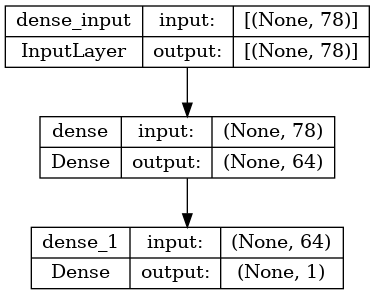

In [28]:
#Define Model
from keras.utils.vis_utils import plot_model
model0 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(x_train.shape[1:])),
    tf.keras.layers.Dense(units=1),
])
model0.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
plot_model(model0, show_shapes=True, show_layer_names=True)


Train on 1305090 samples, validate on 100000 samples
Epoch 1/10
1305090/1305090 [==============================] - 2s 2us/sample - loss: 0.2483 - accuracy: 0.9014 - val_loss: 0.0999 - val_accuracy: 0.9973
Epoch 2/10
1305090/1305090 [==============================] - 2s 1us/sample - loss: 0.0550 - accuracy: 0.9983 - val_loss: 0.0293 - val_accuracy: 0.9988
Epoch 3/10
1305090/1305090 [==============================] - 2s 1us/sample - loss: 0.0210 - accuracy: 0.9987 - val_loss: 0.0156 - val_accuracy: 0.9986
Epoch 4/10
1305090/1305090 [==============================] - 2s 1us/sample - loss: 0.0128 - accuracy: 0.9988 - val_loss: 0.0111 - val_accuracy: 0.9988
Epoch 5/10
1305090/1305090 [==============================] - 2s 1us/sample - loss: 0.0095 - accuracy: 0.9989 - val_loss: 0.0089 - val_accuracy: 0.9988
Epoch 6/10
1305090/1305090 [==============================] - 2s 2us/sample - loss: 0.0077 - accuracy: 0.9990 - val_loss: 0.0076 - val_accuracy: 0.9988
Epoch 7/10
1305090/1305090 [=======

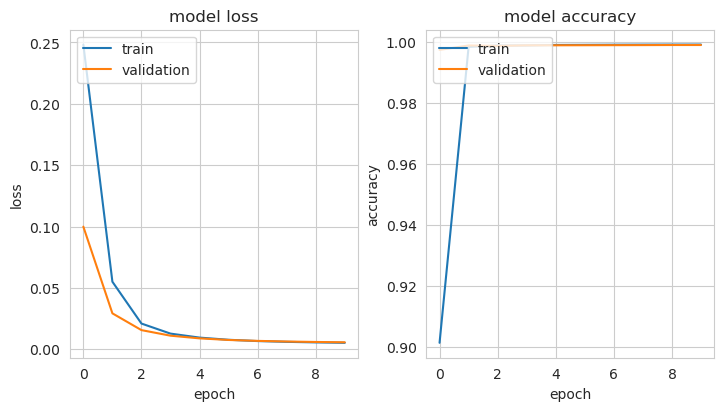

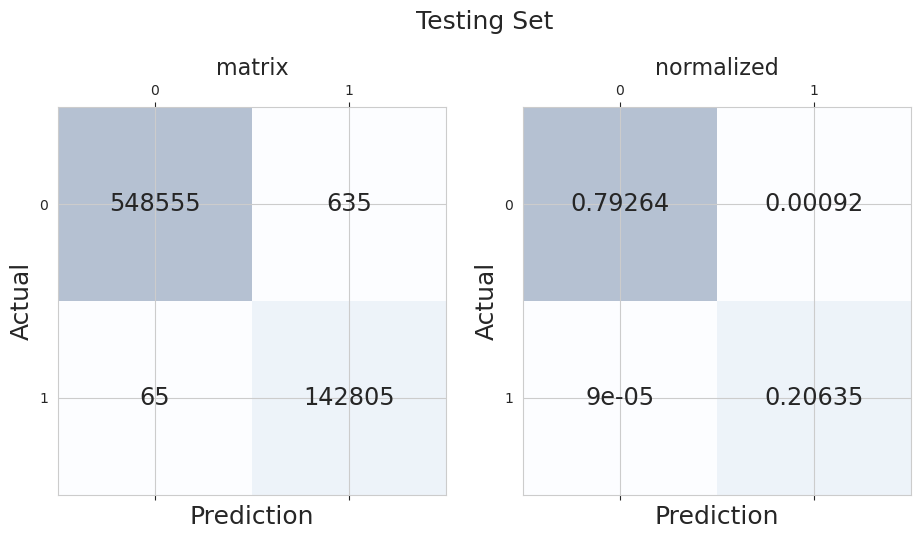

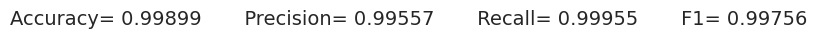

Model: rf
	Description:Radom Forest
	Frame Work: sklearn
	data shape: (100000, 78)
	Fit/TestAll times: [8.128280878067017, 5.894650220870972]
	type: Random Forest Classifier
	Frame Work: sklearn
	Performance metrics:
		test_accuracy 0.99934
		test_precision 0.99733
		test_recall 0.99948
		test_F1 0.99841

		train_accuracy 0.99962
		train_precision 0.99831
		train_recall 0.99985
		train_F1 0.99908
Model: model0
	Description:Shallow ANN one hidden Layer
	Frame Work: keras
	data shape: (1305090, 78)
	Fit/TestAll times: [20.208245515823364, 8.30284595489502]
	type: ANN
	Frame Work: keras
	Performance metrics:
		test_accuracy 0.99899
		test_precision 0.99557
		test_recall 0.99955
		test_F1 0.99756


In [29]:
def fitThenTest(modelName,type, x_train, x_test, y_train,y_test,description,**kwargs):
    model=eval(modelName)
    startTime=time.time()
    history = model.fit(x_train, y_train, **kwargs)
    fitTime=time.time() - startTime  ##################
    plotHistory(history,figsize=(10,4))
    startTime=time.time()
    ev=predictAndEvaluate(model, x_train, x_test, y_train, y_test)
    testTime=time.time() - startTime  ##################
    createMMD(modelName,performance=ev,type=type,data=x_train.shape,
              times=[fitTime,testTime],framework='keras',description=description)
    printMMD()
    
description='Shallow ANN one hidden Layer'
narg={'validation_data':(x_val, y_val), 'epochs':10, 'verbose':1,'batch_size':10000}
fitThenTest('model0','ANN', x_train, x_test, y_train,y_test,description,**narg)
    

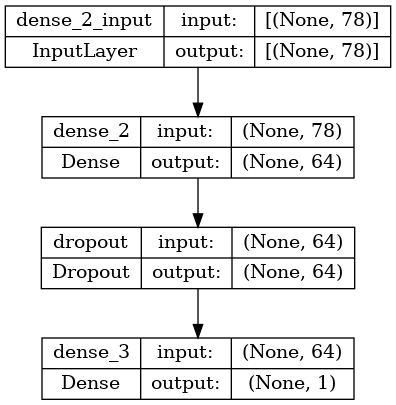

In [30]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(x_train.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    
    tf.keras.layers.Dropout(0.4),
   
    tf.keras.layers.Dense(units=1),
])
model1.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
description='Shallow  ANN one layer & dropout'
plot_model(model1, show_shapes=True, show_layer_names=True)


Train on 1305090 samples, validate on 100000 samples
Epoch 1/10
1305090/1305090 [==============================] - 3s 2us/sample - loss: 0.2927 - accuracy: 0.8923 - val_loss: 0.1159 - val_accuracy: 0.9968
Epoch 2/10
1305090/1305090 [==============================] - 3s 2us/sample - loss: 0.0844 - accuracy: 0.9919 - val_loss: 0.0455 - val_accuracy: 0.9984
Epoch 3/10
1305090/1305090 [==============================] - 3s 2us/sample - loss: 0.0427 - accuracy: 0.9978 - val_loss: 0.0289 - val_accuracy: 0.9985
Epoch 4/10
1305090/1305090 [==============================] - 3s 2us/sample - loss: 0.0307 - accuracy: 0.9982 - val_loss: 0.0233 - val_accuracy: 0.9986
Epoch 5/10
1305090/1305090 [==============================] - 3s 2us/sample - loss: 0.0253 - accuracy: 0.9985 - val_loss: 0.0205 - val_accuracy: 0.9987
Epoch 6/10
1305090/1305090 [==============================] - 3s 2us/sample - loss: 0.0225 - accuracy: 0.9986 - val_loss: 0.0188 - val_accuracy: 0.9987
Epoch 7/10
1305090/1305090 [=======

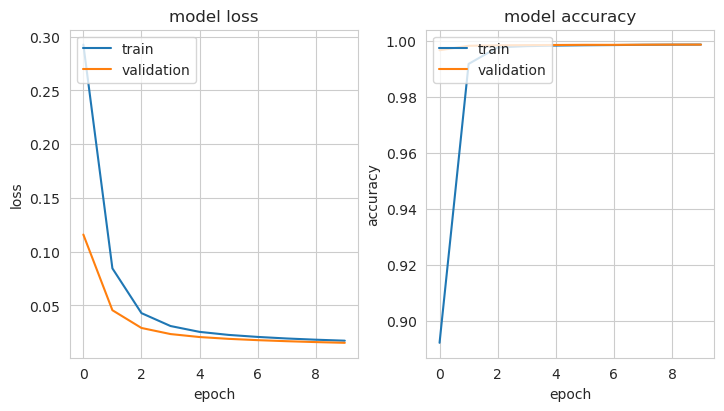

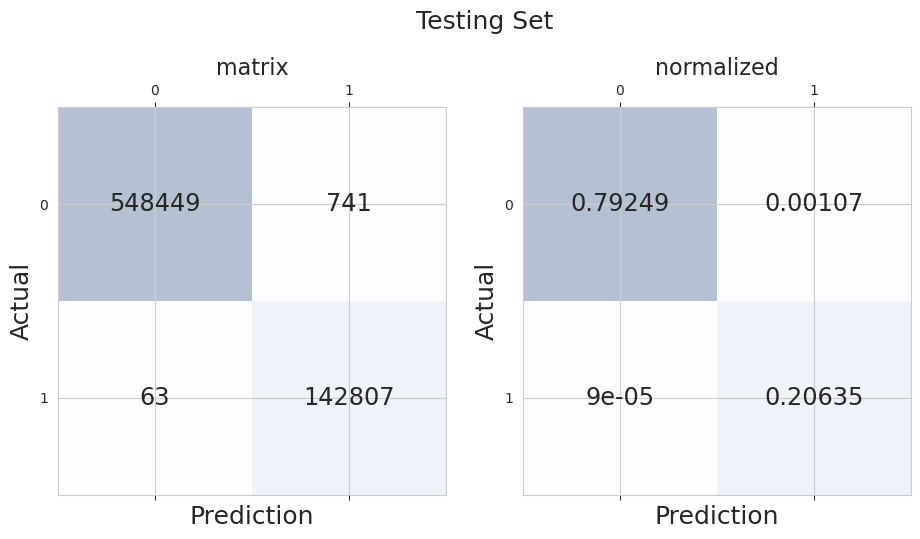

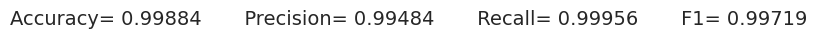

Model: rf
	Description:Radom Forest
	Frame Work: sklearn
	data shape: (100000, 78)
	Fit/TestAll times: [8.128280878067017, 5.894650220870972]
	type: Random Forest Classifier
	Frame Work: sklearn
	Performance metrics:
		test_accuracy 0.99934
		test_precision 0.99733
		test_recall 0.99948
		test_F1 0.99841

		train_accuracy 0.99962
		train_precision 0.99831
		train_recall 0.99985
		train_F1 0.99908
Model: model0
	Description:Shallow ANN one hidden Layer
	Frame Work: keras
	data shape: (1305090, 78)
	Fit/TestAll times: [20.208245515823364, 8.30284595489502]
	type: ANN
	Frame Work: keras
	Performance metrics:
		test_accuracy 0.99899
		test_precision 0.99557
		test_recall 0.99955
		test_F1 0.99756
Model: model1
	Description:Shallow  ANN one layer & dropout
	Frame Work: keras
	data shape: (1305090, 78)
	Fit/TestAll times: [27.922301292419434, 9.703494548797607]
	type: ANN+dropout
	Frame Work: keras
	Performance metrics:
		test_accuracy 0.99884
		test_precision 0.99484
		test_recall 0.99956
	

In [31]:

narg={'validation_data':(x_val, y_val), 'epochs':10, 'verbose':1,'batch_size':10000}
fitThenTest('model1','ANN+dropout', x_train, x_test, y_train, y_test,description,**narg)


Train on 1305090 samples, validate on 100000 samples
Epoch 1/10
1305090/1305090 [==============================] - 5s 4us/sample - loss: 0.2230 - accuracy: 0.9179 - val_loss: 0.0370 - val_accuracy: 0.9986
Epoch 2/10
1305090/1305090 [==============================] - 5s 4us/sample - loss: 0.0393 - accuracy: 0.9979 - val_loss: 0.0304 - val_accuracy: 0.9988
Epoch 3/10
1305090/1305090 [==============================] - 5s 4us/sample - loss: 0.0317 - accuracy: 0.9988 - val_loss: 0.0268 - val_accuracy: 0.9991
Epoch 4/10
1305090/1305090 [==============================] - 5s 4us/sample - loss: 0.0277 - accuracy: 0.9990 - val_loss: 0.0239 - val_accuracy: 0.9992
Epoch 5/10
1305090/1305090 [==============================] - 5s 4us/sample - loss: 0.0245 - accuracy: 0.9990 - val_loss: 0.0215 - val_accuracy: 0.9992
Epoch 6/10
1305090/1305090 [==============================] - 5s 4us/sample - loss: 0.0218 - accuracy: 0.9991 - val_loss: 0.0193 - val_accuracy: 0.9992
Epoch 7/10
1305090/1305090 [=======

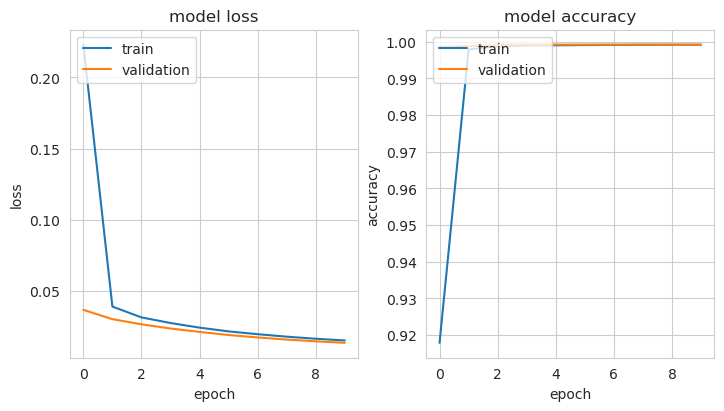

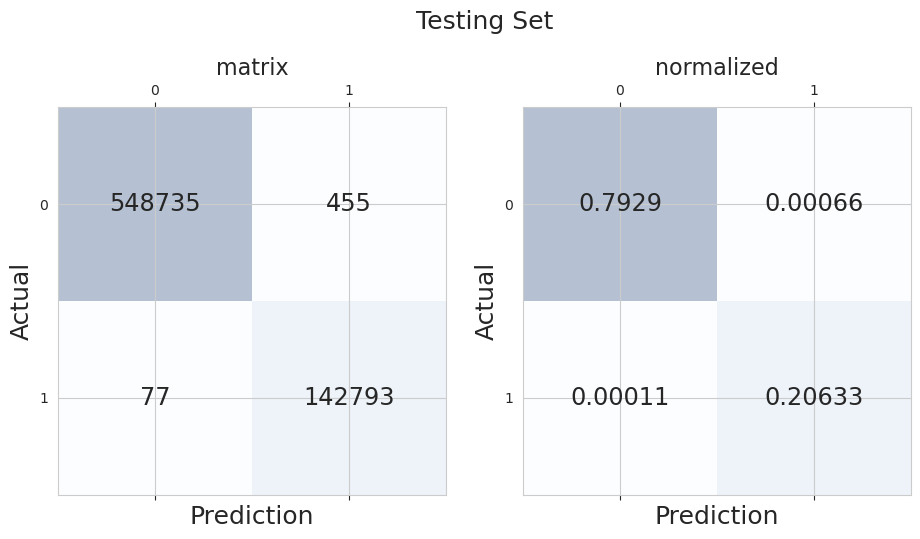

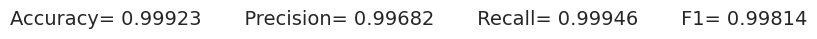

Model: rf
	Description:Radom Forest
	Frame Work: sklearn
	data shape: (100000, 78)
	Fit/TestAll times: [8.128280878067017, 5.894650220870972]
	type: Random Forest Classifier
	Frame Work: sklearn
	Performance metrics:
		test_accuracy 0.99934
		test_precision 0.99733
		test_recall 0.99948
		test_F1 0.99841

		train_accuracy 0.99962
		train_precision 0.99831
		train_recall 0.99985
		train_F1 0.99908
Model: model0
	Description:Shallow ANN one hidden Layer
	Frame Work: keras
	data shape: (1305090, 78)
	Fit/TestAll times: [20.208245515823364, 8.30284595489502]
	type: ANN
	Frame Work: keras
	Performance metrics:
		test_accuracy 0.99899
		test_precision 0.99557
		test_recall 0.99955
		test_F1 0.99756
Model: model1
	Description:Shallow  ANN one layer & dropout
	Frame Work: keras
	data shape: (1305090, 78)
	Fit/TestAll times: [27.922301292419434, 9.703494548797607]
	type: ANN+dropout
	Frame Work: keras
	Performance metrics:
		test_accuracy 0.99884
		test_precision 0.99484
		test_recall 0.99956
	

In [32]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(x_train.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(units=1) #, activation='sigmoid'),
])
model2.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

description='MLP two layers & dropout'
narg={'validation_data':(x_val, y_val), 'epochs':10, 'verbose':1,'batch_size':10000}
fitThenTest('model2','Dense MLP', x_train, x_test, y_train, y_test,description,**narg) 

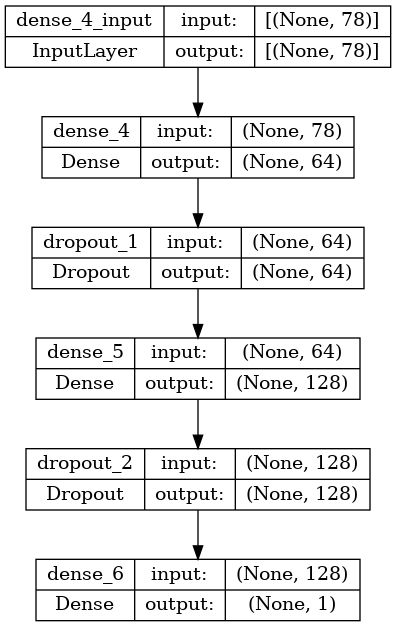

In [33]:
plot_model(model2, show_shapes=True, show_layer_names=True)

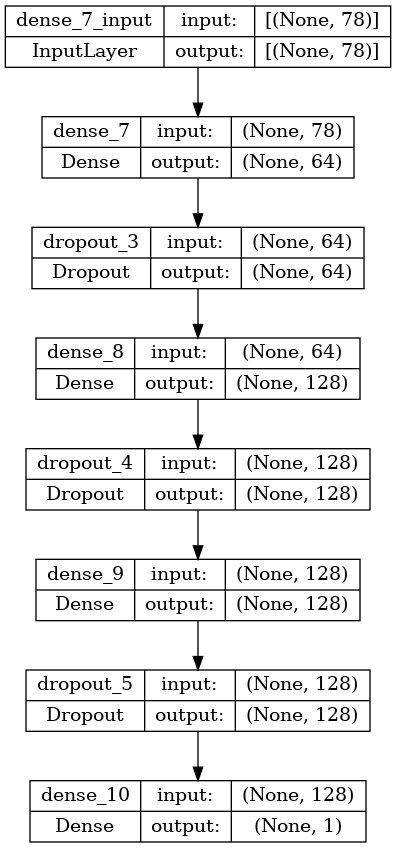

In [34]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(x_train.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(units=1) #, activation='sigmoid'),
])
model4.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
description='Dense MLP 4 layers & dropout'
plot_model(model4, show_shapes=True, show_layer_names=True)
 

Train on 1305090 samples, validate on 100000 samples
Epoch 1/10
1305090/1305090 [==============================] - 7s 6us/sample - loss: 0.1963 - accuracy: 0.9165 - val_loss: 0.0545 - val_accuracy: 0.9988
Epoch 2/10
1305090/1305090 [==============================] - 7s 5us/sample - loss: 0.0529 - accuracy: 0.9987 - val_loss: 0.0435 - val_accuracy: 0.9991
Epoch 3/10
1305090/1305090 [==============================] - 7s 5us/sample - loss: 0.0416 - accuracy: 0.9990 - val_loss: 0.0356 - val_accuracy: 0.9992
Epoch 4/10
1305090/1305090 [==============================] - 7s 5us/sample - loss: 0.0346 - accuracy: 0.9992 - val_loss: 0.0300 - val_accuracy: 0.9992
Epoch 5/10
1305090/1305090 [==============================] - 7s 5us/sample - loss: 0.0294 - accuracy: 0.9992 - val_loss: 0.0256 - val_accuracy: 0.9992
Epoch 6/10
1305090/1305090 [==============================] - 7s 5us/sample - loss: 0.0251 - accuracy: 0.9992 - val_loss: 0.0221 - val_accuracy: 0.9992
Epoch 7/10
1305090/1305090 [=======

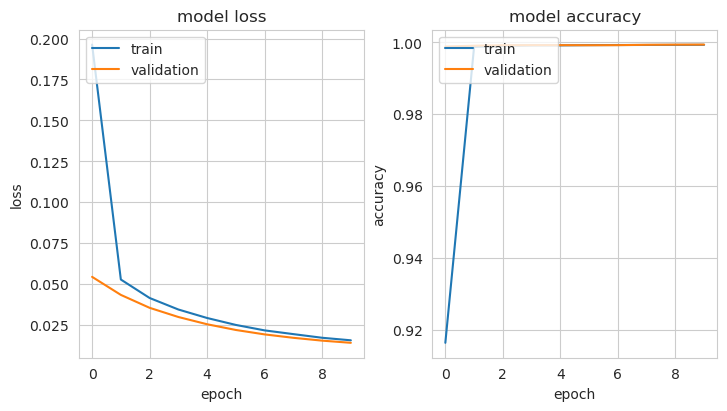

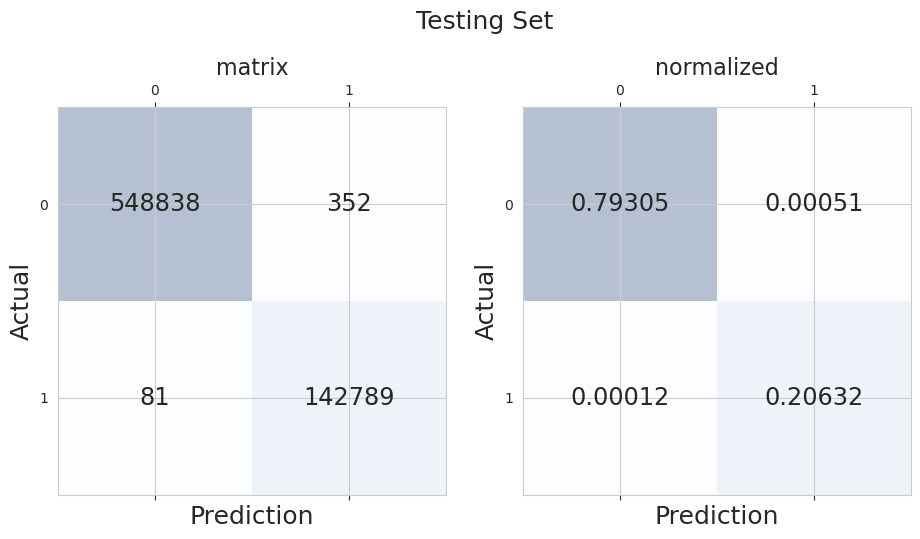

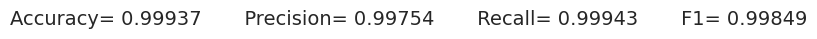

Model: rf
	Description:Radom Forest
	Frame Work: sklearn
	data shape: (100000, 78)
	Fit/TestAll times: [8.128280878067017, 5.894650220870972]
	type: Random Forest Classifier
	Frame Work: sklearn
	Performance metrics:
		test_accuracy 0.99934
		test_precision 0.99733
		test_recall 0.99948
		test_F1 0.99841

		train_accuracy 0.99962
		train_precision 0.99831
		train_recall 0.99985
		train_F1 0.99908
Model: model0
	Description:Shallow ANN one hidden Layer
	Frame Work: keras
	data shape: (1305090, 78)
	Fit/TestAll times: [20.208245515823364, 8.30284595489502]
	type: ANN
	Frame Work: keras
	Performance metrics:
		test_accuracy 0.99899
		test_precision 0.99557
		test_recall 0.99955
		test_F1 0.99756
Model: model1
	Description:Shallow  ANN one layer & dropout
	Frame Work: keras
	data shape: (1305090, 78)
	Fit/TestAll times: [27.922301292419434, 9.703494548797607]
	type: ANN+dropout
	Frame Work: keras
	Performance metrics:
		test_accuracy 0.99884
		test_precision 0.99484
		test_recall 0.99956
	

In [35]:
narg={'validation_data':(x_val, y_val), 'epochs':10, 'verbose':1,'batch_size':10000}
fitThenTest('model4','Dense MLP', x_train, x_test, y_train, y_test,description,**narg)

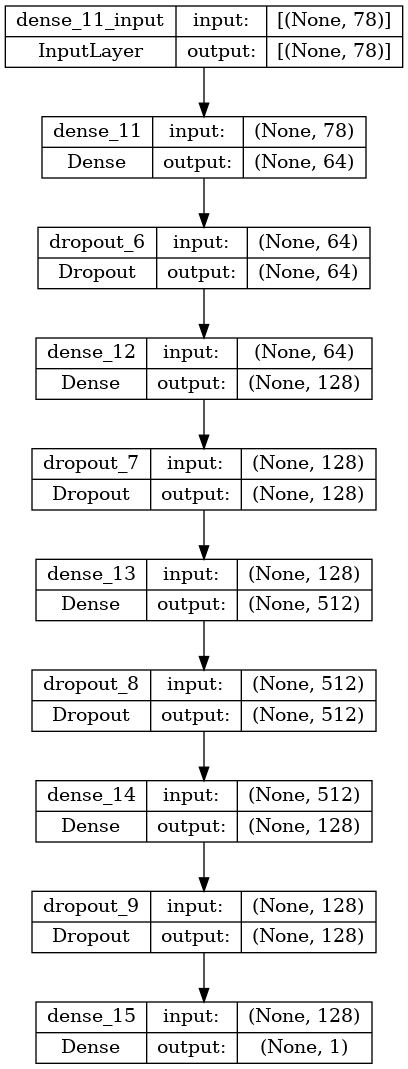

In [36]:
model6 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(x_train.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=1) #, activation='sigmoid'),
])
description='Dense MLP 6 layers & dropout layers'
model6.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

plot_model(model6,  show_shapes=True, show_layer_names=True)
#model.summary()


Train on 1305090 samples, validate on 100000 samples
Epoch 1/10
1305090/1305090 [==============================] - 18s 14us/sample - loss: 0.2192 - accuracy: 0.9468 - val_loss: 0.0986 - val_accuracy: 0.9989
Epoch 2/10
1305090/1305090 [==============================] - 17s 13us/sample - loss: 0.0834 - accuracy: 0.9989 - val_loss: 0.0655 - val_accuracy: 0.9992
Epoch 3/10
1305090/1305090 [==============================] - 17s 13us/sample - loss: 0.0570 - accuracy: 0.9991 - val_loss: 0.0465 - val_accuracy: 0.9992
Epoch 4/10
1305090/1305090 [==============================] - 17s 13us/sample - loss: 0.0415 - accuracy: 0.9992 - val_loss: 0.0346 - val_accuracy: 0.9992
Epoch 5/10
1305090/1305090 [==============================] - 17s 13us/sample - loss: 0.0325 - accuracy: 0.9992 - val_loss: 0.0277 - val_accuracy: 0.9992
Epoch 6/10
1305090/1305090 [==============================] - 17s 13us/sample - loss: 0.0261 - accuracy: 0.9993 - val_loss: 0.0224 - val_accuracy: 0.9994
Epoch 7/10
1305090/1305

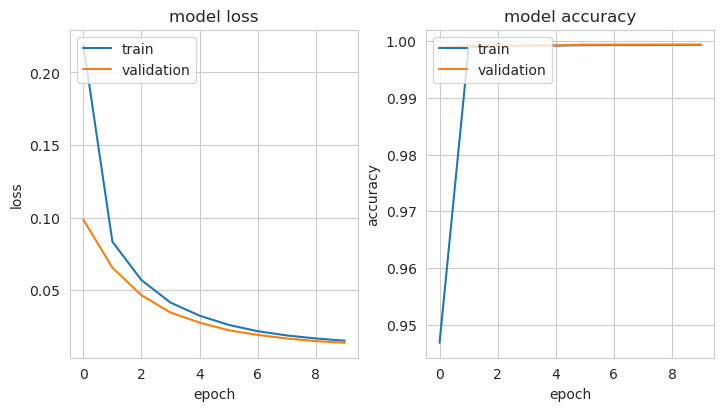

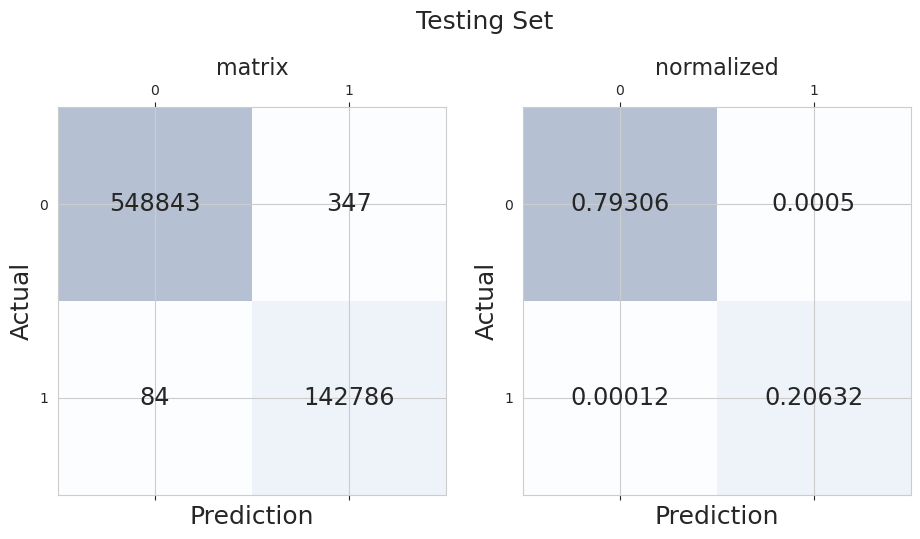

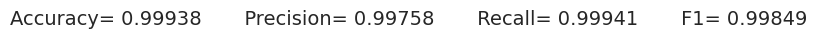

Model: rf
	Description:Radom Forest
	Frame Work: sklearn
	data shape: (100000, 78)
	Fit/TestAll times: [8.128280878067017, 5.894650220870972]
	type: Random Forest Classifier
	Frame Work: sklearn
	Performance metrics:
		test_accuracy 0.99934
		test_precision 0.99733
		test_recall 0.99948
		test_F1 0.99841

		train_accuracy 0.99962
		train_precision 0.99831
		train_recall 0.99985
		train_F1 0.99908
Model: model0
	Description:Shallow ANN one hidden Layer
	Frame Work: keras
	data shape: (1305090, 78)
	Fit/TestAll times: [20.208245515823364, 8.30284595489502]
	type: ANN
	Frame Work: keras
	Performance metrics:
		test_accuracy 0.99899
		test_precision 0.99557
		test_recall 0.99955
		test_F1 0.99756
Model: model1
	Description:Shallow  ANN one layer & dropout
	Frame Work: keras
	data shape: (1305090, 78)
	Fit/TestAll times: [27.922301292419434, 9.703494548797607]
	type: ANN+dropout
	Frame Work: keras
	Performance metrics:
		test_accuracy 0.99884
		test_precision 0.99484
		test_recall 0.99956
	

In [37]:
narg={'validation_data':(x_val, y_val), 'epochs':10, 'verbose':1,'batch_size':10000}
fitThenTest('model6','Dense MLP', x_train, x_test, y_train, y_test,description,**narg)    

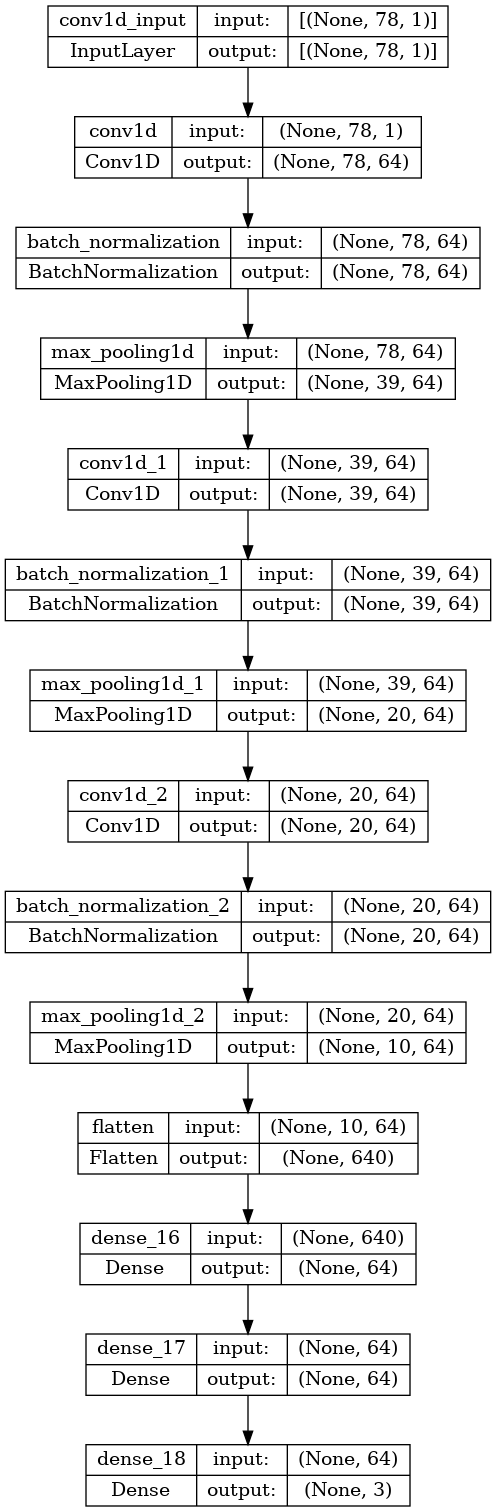

In [38]:
try: del CnnMod
except: pass
# making the deep CNN NModel
from keras.layers import  Conv1D,  MaxPooling1D,BatchNormalization,Flatten,Dense
#print(x_train.shape[1])
def modelCNN():
    model=tf.keras.Sequential()
    #model.add(tf.keras.layers.Dense(units=64, activation='relu', input_shape=(x_train.shape[1:])))
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(x_train.shape[1],1)))
    model.add(BatchNormalization())
    
    # adding a pooling layer
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(72, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(72, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
CnnMod = modelCNN()
description='CNN Model'
plot_model(CnnMod,  show_shapes=True, show_layer_names=True)

# <span style="color:red"> -----> Hatlt Cell Continue After

In [39]:
# <span style="color:red"> -----> Hatlt Cell Continue After
raise KeyboardInterrupt

KeyboardInterrupt: 

# CNN

In [40]:
def prepCNNData(x_train,x_test, y_train, y_test):
    SAMPLESIZE=100000
    X_train=np.array(x_train[:SAMPLESIZE])
    X_test=np.array(x_test[:SAMPLESIZE])
    Y_train=y_train[:SAMPLESIZE]
    Y_test=y_test[:SAMPLESIZE]

    X_val=np.array(x_train[SAMPLESIZE:SAMPLESIZE+10000])
    Y_val=np.array(y_train[SAMPLESIZE:SAMPLESIZE+10000])

    X_train =X_train.reshape(SAMPLESIZE, x_train.shape[1], 1)
    X_test = X_test.reshape(SAMPLESIZE, x_test.shape[1], 1)
    X_val = X_val.reshape(10000, X_val.shape[1], 1)
    ev=[X_train,X_test, Y_train, Y_test,X_val,Y_val]
    return ev

def eval_cnn(modelName,x_train, x_test, y_train, y_test,history,fitTime):
    model=eval(modelName)
    plotHistory(history,figsize=(10,4))
    startTime=time.time()
    test_predict1=model.predict(x_test)
    #test_cm=metrics.confusion_matrix(Y_test, test_predict)
    test_predict1 = np.where(test_predict1 > 0.5, 1.0, 0.0)
    test_predict=test_predict1[:,1]
    test_cm=metrics.confusion_matrix(y_test, test_predict)
    test_accuracy = metrics.accuracy_score(y_test, test_predict)
    test_precision = metrics.precision_score(y_test, test_predict)
    test_recall = metrics.recall_score(y_test, test_predict)
    test_F1=2*test_precision*test_recall/(test_precision+test_recall)
    ev=[test_cm,test_accuracy,test_precision,test_recall,test_F1]
    print('---->',ev)
    testTime=time.time() - startTime  ##################
    matrix = test_cm
    matrixN = matrix.astype('float') / matrix.sum()
    frmt="Accuracy= {:.5f}       Precision= {:.5f}       Recall= {:.5f}       F1= {:.5f}"
    st=frmt.format(test_accuracy,test_precision,test_recall,test_F1)
    plotConfusion(matrix,matrixN,"Testing Set",st)
    description='CNN neural Network'
    createMMD(modelName,performance=ev,type='CNN',data=x_train.shape,
              times=[fitTime,testTime],framework='keras',description=description)
    printMMD()
    
X_train,X_test, Y_train, Y_test,X_val,Y_val=\
    prepCNNData(x_train,x_test, y_train, y_test)



# CNN very poor with 10 epochs !

Train on 100000 samples, validate on 10000 samples
Epoch 1/25
100000/100000 [==============================] - 21s 208us/sample - loss: 0.2245 - accuracy: 0.8947 - val_loss: 0.9042 - val_accuracy: 0.8620
Epoch 2/25
100000/100000 [==============================] - 20s 201us/sample - loss: 0.0105 - accuracy: 0.9984 - val_loss: 0.8435 - val_accuracy: 0.9455
Epoch 3/25
100000/100000 [==============================] - 20s 198us/sample - loss: 0.0060 - accuracy: 0.9987 - val_loss: 0.7755 - val_accuracy: 0.9099
Epoch 4/25
100000/100000 [==============================] - 20s 202us/sample - loss: 0.0050 - accuracy: 0.9990 - val_loss: 0.7109 - val_accuracy: 0.9112
Epoch 5/25
100000/100000 [==============================] - 21s 206us/sample - loss: 0.0046 - accuracy: 0.9990 - val_loss: 0.6602 - val_accuracy: 0.8685
Epoch 6/25
100000/100000 [==============================] - 20s 202us/sample - loss: 0.0045 - accuracy: 0.9992 - val_loss: 0.6084 - val_accuracy: 0.8689
Epoch 7/25
100000/100000 [=====

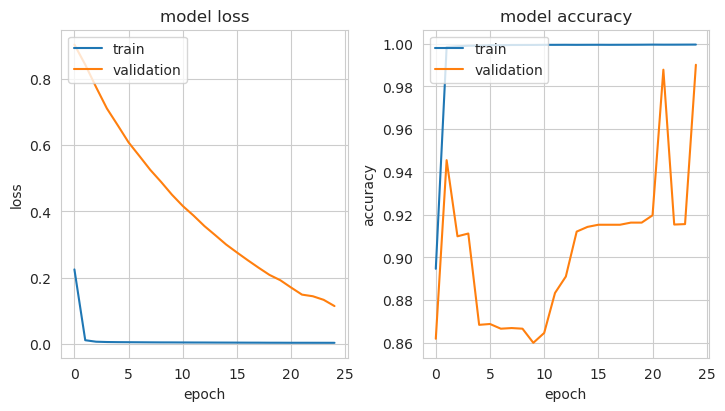

----> [array([[79418,    61],
       [  925, 19596]]), 0.99014, 0.9968967797731089, 0.9549242239656937, 0.9754592065309374]


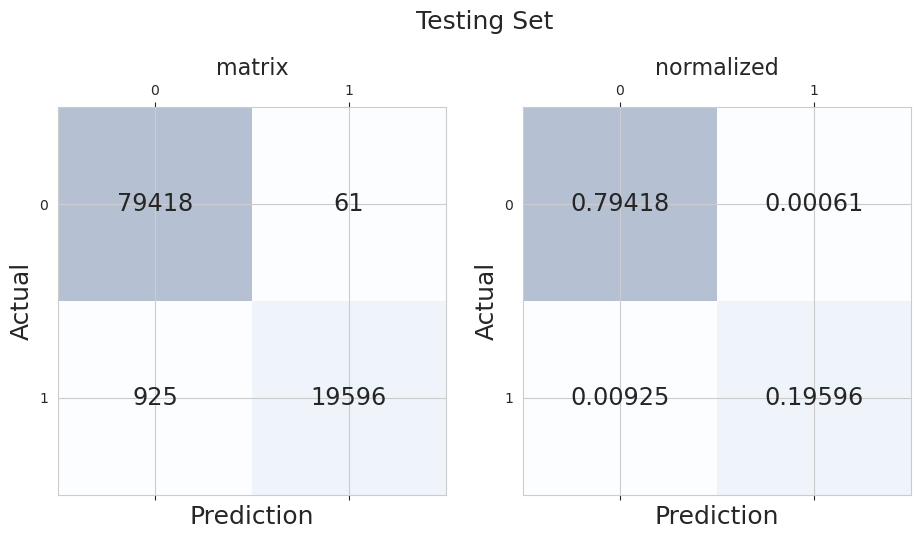

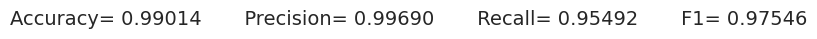

Model: rf
	Description:Radom Forest
	Frame Work: sklearn
	data shape: (100000, 78)
	Fit/TestAll times: [8.128280878067017, 5.894650220870972]
	type: Random Forest Classifier
	Frame Work: sklearn
	Performance metrics:
		test_accuracy 0.99934
		test_precision 0.99733
		test_recall 0.99948
		test_F1 0.99841

		train_accuracy 0.99962
		train_precision 0.99831
		train_recall 0.99985
		train_F1 0.99908
Model: model0
	Description:Shallow ANN one hidden Layer
	Frame Work: keras
	data shape: (1305090, 78)
	Fit/TestAll times: [20.208245515823364, 8.30284595489502]
	type: ANN
	Frame Work: keras
	Performance metrics:
		test_accuracy 0.99899
		test_precision 0.99557
		test_recall 0.99955
		test_F1 0.99756
Model: model1
	Description:Shallow  ANN one layer & dropout
	Frame Work: keras
	data shape: (1305090, 78)
	Fit/TestAll times: [27.922301292419434, 9.703494548797607]
	type: ANN+dropout
	Frame Work: keras
	Performance metrics:
		test_accuracy 0.99884
		test_precision 0.99484
		test_recall 0.99956
	

In [41]:
# At least needs 20 epochs
startTime=time.time()
history = CnnMod.fit(X_train, Y_train, epochs=25, verbose=1,\
                     validation_data=(X_val, Y_val),batch_size=10000,)
fitTime=time.time() - startTime  ##################
ev=eval_cnn('CnnMod',X_train, X_test, X_train, Y_test,history,fitTime)

In [42]:
'''
px(model,X_train, X_test, X_train, Y_test):
    test_predict1=CnnMod.predict(X_test)
    #test_cm=metrics.confusion_matrix(Y_test, test_predict)
    test_predict1 = np.where(test_predict > 0.5, 1.0, 0.0)
    test_predict=test_predict1[:,1]
    test_cm=metrics.confusion_matrix(Y_test, test_predict)
    test_accuracy = metrics.accuracy_score(y_test, test_predict)
    test_precision = metrics.precision_score(y_test, test_predict)
    test_recall = metrics.recall_score(y_test, test_predict)
    test_F1=2*test_precision*test_recall/(test_precision+test_recall)
    return test_cm,test_accuracy,test_precision,test_recall,test_F1
ev=
test_cm,test_accuracy,test_precision,test_recall,test_F1=ev
'''
print()

# Other Classical (using Scikit) Models

In [43]:
def evClassical(modelName,x_train, x_test, y_train, y_test,fitTime,type="",description=""):
    model=eval(modelName)
    startTime=time.time()
    ev=predictAndEvaluate(model, x_train, x_test, y_train, y_test)
    testTime=time.time() - startTime  ##################
    
    createMMD(modelName,performance=ev,type=type,data=x_train.shape,\
              times=[fitTime,testTime],description=description)
    printMMD()

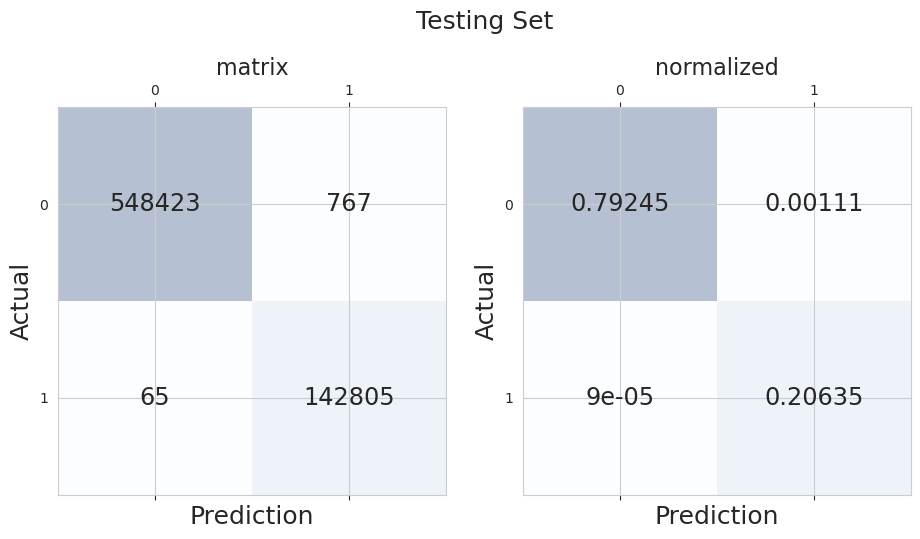

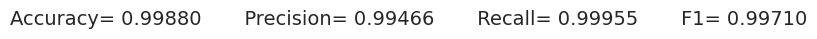

Model: rf
	Description:Radom Forest
	Frame Work: sklearn
	data shape: (100000, 78)
	Fit/TestAll times: [8.128280878067017, 5.894650220870972]
	type: Random Forest Classifier
	Frame Work: sklearn
	Performance metrics:
		test_accuracy 0.99934
		test_precision 0.99733
		test_recall 0.99948
		test_F1 0.99841

		train_accuracy 0.99962
		train_precision 0.99831
		train_recall 0.99985
		train_F1 0.99908
Model: model0
	Description:Shallow ANN one hidden Layer
	Frame Work: keras
	data shape: (1305090, 78)
	Fit/TestAll times: [20.208245515823364, 8.30284595489502]
	type: ANN
	Frame Work: keras
	Performance metrics:
		test_accuracy 0.99899
		test_precision 0.99557
		test_recall 0.99955
		test_F1 0.99756
Model: model1
	Description:Shallow  ANN one layer & dropout
	Frame Work: keras
	data shape: (1305090, 78)
	Fit/TestAll times: [27.922301292419434, 9.703494548797607]
	type: ANN+dropout
	Frame Work: keras
	Performance metrics:
		test_accuracy 0.99884
		test_precision 0.99484
		test_recall 0.99956
	

In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
startTime=time.time()
lrMod = LogisticRegression(max_iter=10000).fit(x_train_sample, y_train_sample)
fitTime=time.time()-startTime
description='Vanilla Logistic Regression'
evClassical('lrMod',x_train_sample, x_test, y_train_sample, y_test,fitTime,type='Logit',description=description)


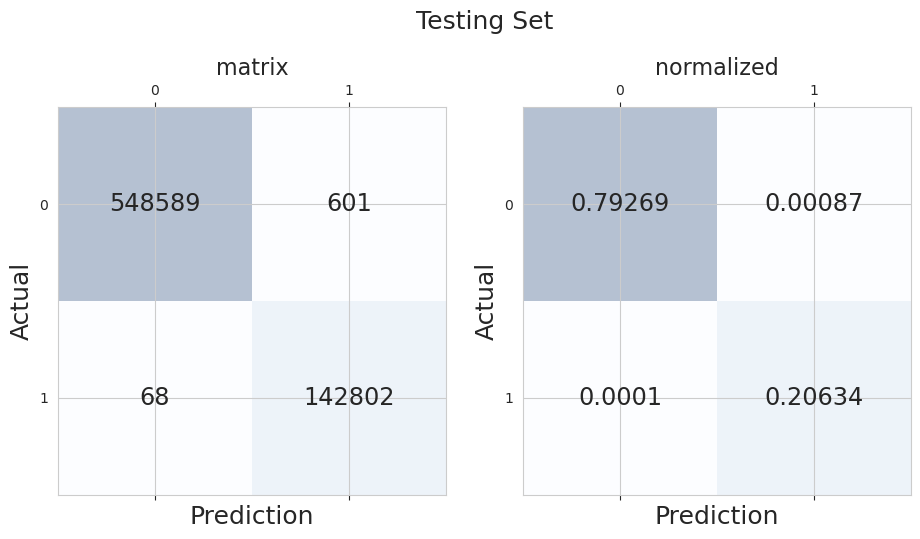

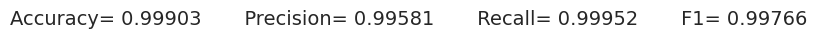

Model: rf
	Description:Radom Forest
	Frame Work: sklearn
	data shape: (100000, 78)
	Fit/TestAll times: [8.128280878067017, 5.894650220870972]
	type: Random Forest Classifier
	Frame Work: sklearn
	Performance metrics:
		test_accuracy 0.99934
		test_precision 0.99733
		test_recall 0.99948
		test_F1 0.99841

		train_accuracy 0.99962
		train_precision 0.99831
		train_recall 0.99985
		train_F1 0.99908
Model: model0
	Description:Shallow ANN one hidden Layer
	Frame Work: keras
	data shape: (1305090, 78)
	Fit/TestAll times: [20.208245515823364, 8.30284595489502]
	type: ANN
	Frame Work: keras
	Performance metrics:
		test_accuracy 0.99899
		test_precision 0.99557
		test_recall 0.99955
		test_F1 0.99756
Model: model1
	Description:Shallow  ANN one layer & dropout
	Frame Work: keras
	data shape: (1305090, 78)
	Fit/TestAll times: [27.922301292419434, 9.703494548797607]
	type: ANN+dropout
	Frame Work: keras
	Performance metrics:
		test_accuracy 0.99884
		test_precision 0.99484
		test_recall 0.99956
	

In [45]:
from sklearn import svm
#Create a svm Classifier 5 minutes and more
stim=time.time()
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(x_train[:100000], y_train[:100000])
fitTime=time.time()-stim
#Predict the response for test dataset
description='Support Vector Machine'
evClassical('clf',x_train[:100000], x_test, y_train[:100000], y_test,fitTime,type='SVM',description=description)
#createMMD('clf',performance=ev,type=type,data=x_train.shape,times=[fitTime,testTime])


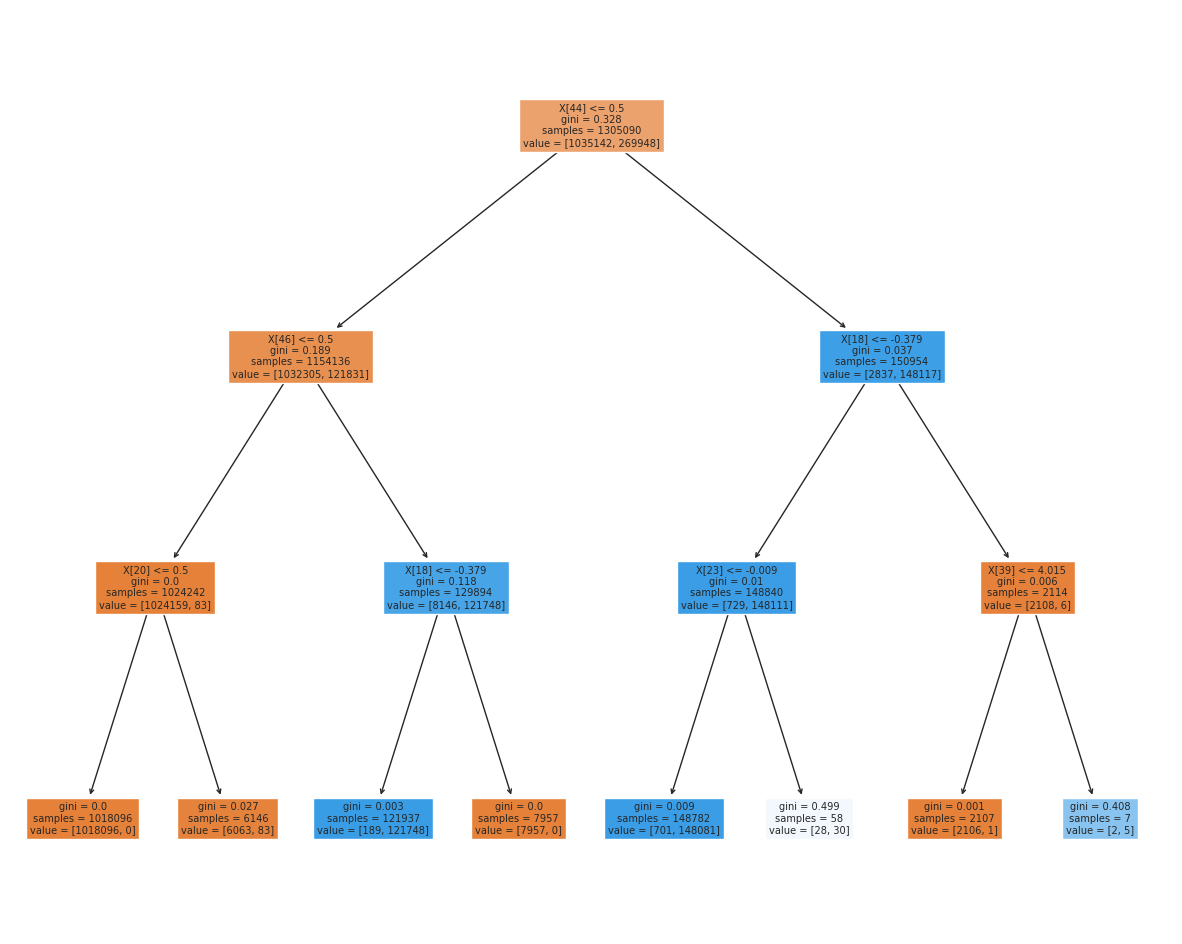

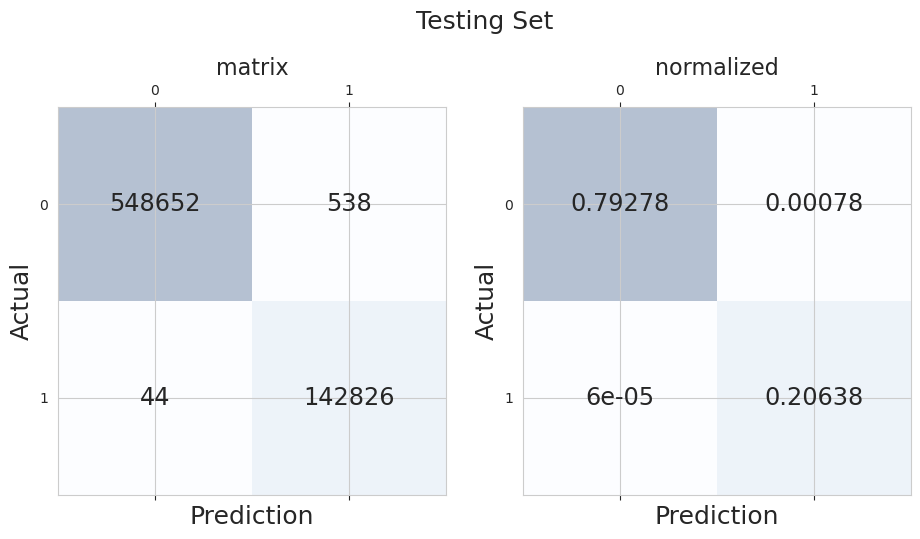

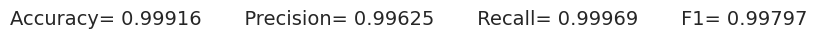

Model: rf
	Description:Radom Forest
	Frame Work: sklearn
	data shape: (100000, 78)
	Fit/TestAll times: [8.128280878067017, 5.894650220870972]
	type: Random Forest Classifier
	Frame Work: sklearn
	Performance metrics:
		test_accuracy 0.99934
		test_precision 0.99733
		test_recall 0.99948
		test_F1 0.99841

		train_accuracy 0.99962
		train_precision 0.99831
		train_recall 0.99985
		train_F1 0.99908
Model: model0
	Description:Shallow ANN one hidden Layer
	Frame Work: keras
	data shape: (1305090, 78)
	Fit/TestAll times: [20.208245515823364, 8.30284595489502]
	type: ANN
	Frame Work: keras
	Performance metrics:
		test_accuracy 0.99899
		test_precision 0.99557
		test_recall 0.99955
		test_F1 0.99756
Model: model1
	Description:Shallow  ANN one layer & dropout
	Frame Work: keras
	data shape: (1305090, 78)
	Fit/TestAll times: [27.922301292419434, 9.703494548797607]
	type: ANN+dropout
	Frame Work: keras
	Performance metrics:
		test_accuracy 0.99884
		test_precision 0.99484
		test_recall 0.99956
	

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
stim=time.time()
dt = DecisionTreeClassifier(max_depth=3).fit(x_train, y_train)
#dt.fit(x_train, y_train)
ftim=time.time()-stim
fig = plt.figure(figsize=(15,12))
tree.plot_tree(dt , filled=True)
description='Simple Decision Tree'
evClassical('dt',x_train[:100000], x_test, y_train[:100000], y_test,ftim,type='Decision Tree',description=description)

# <span style="color:red"> -----> Hatlt Cell Continue After

In [47]:
# <span style="color:red"> -----> Hatlt Cell Continue After
raise KeyboardInterrupt

KeyboardInterrupt: 

In [48]:
from random import randint
rand_idx = randint(0,y_test.shape[0])
rand_idx=1
print(y_test[:3])
label=y_test.tolist()[rand_idx]

sample=x_test[rand_idx:rand_idx+1]
label=y_test.tolist()[rand_idx]
mod=rf
pred=mod.predict(sample)
print(label,"->",pred)
print(predict(mod,sample))
#print(model0(sample).dtype)
print(mod.predict_proba(sample))


76608     0
25825     1
792140    0
Name: Label, dtype: int64
1 -> [1]
(array([1.]), array([1]))
[[0.01140629 0.98859371]]


In [69]:
# Test Sample
# Test Benign SET Y=0, Test Malicious SET Y=1
Y=1
ind=y_test.index[y_test==Y].tolist()
index=ind[0]
sampleX=x_test.iloc[[index]]
sampleY=y_test[index]
print(sampleY)
sampleX


#x_testART, y_testART=x_test[:TestSampleSize],y_test[:TestSampleSize]

1


,ACK Flag Cnt,Active Max,Active Mean,Active Min,Active Std,Bwd Header Len,Bwd IAT Max,Bwd IAT Mean,Bwd IAT Min,Bwd IAT Std,...,SYN Flag Cnt,Subflow Bwd Byts,Subflow Bwd Pkts,Subflow Fwd Byts,Subflow Fwd Pkts,Tot Bwd Pkts,Tot Fwd Pkts,TotLen Bwd Pkts,TotLen Fwd Pkts,URG Flag Cnt
294597,0,-0.134716,-0.104232,-0.084267,-0.112973,-0.059769,-0.25421,-0.175097,-0.078418,-0.257554,...,0,-0.032391,-0.057337,-0.019027,-0.118373,-0.057337,-0.118373,-0.032391,-0.019027,0


# Invading Scikit Classifiers

In [111]:
epsList=[0.02,.04,0.06,.08,.1,.15,.2]
from art.estimators.classification import SklearnClassifier

def Test_FGSM_SK(modelName,x_test,y_test,TestSampleSize=10000,eps=[.1]):
    x_testART, y_testART=x_test[:TestSampleSize],y_test[:TestSampleSize]
    classifier = SklearnClassifier(model=eval(modelName))
    predictions = classifier.predict(x_testART)
    yt=np.array(y_testART)
    yt = np.where(yt > 0.5, 1.0, 0.0)
    yp=np.array(predictions[:,1])
    yp = np.where(yp > 0.5, 1.0, 0.0)
    print(yt[:10])
    print(yp[:10])
    cmClass=metrics.confusion_matrix(yt,yp)
    print(cmClass)
    acc = metrics.accuracy_score(yt,yp )
    precision = metrics.precision_score(yt,yp)
    recall = metrics.recall_score(yt,yp)
    F1=2*precision*recall/(precision+recall)
    if np.isnan(F1): F1=0
    print(acc,precision,recall,F1)
    dict={}
    dict[0.0]=[cmClass,acc,precision,recall,F1]
    for eps_ in eps:
        print ('eps=',eps_)
        attack = FastGradientMethod(estimator=classifier, eps=eps_)
        x_test_adv = attack.generate(x=np.array(x_testART))
        predictions2 = classifier.predict(x_test_adv)
        yp=np.array(predictions2[:,1])
        yp = np.where(yp > 0.5, 1.0, 0.0)
        cmClass=metrics.confusion_matrix(yt,yp)
        print(cmClass)
        acc = metrics.accuracy_score(yt,yp )
        precision = metrics.precision_score(yt,yp)
        recall = metrics.recall_score(yt,yp)
        F1=2*precision*recall/(precision+recall)
        if np.isnan(F1): F1=0
        print(acc,precision,recall,F1)
        print('F1',F1)
        dict[eps_]=[cmClass,acc,precision,recall,F1]
    return dict
#Test_FGSM_SK('lrMod ',x_test,y_test,eps=epsList)


[0. 1. 0. 0. 1. 0. 0. 0. 0. 1.]
[0. 1. 0. 0. 1. 0. 0. 0. 0. 1.]
[[7987   13]
 [   1 1999]]
0.9986 0.9935387673956262 0.9995 0.9965104685942173
eps= 0.02
[[7977   23]
 [   1 1999]]
0.9976 0.9886251236399605 0.9995 0.9940328194927895
F1 0.9940328194927895
eps= 0.04
[[7959   41]
 [  30 1970]]
0.9929 0.9796121332670313 0.985 0.9822986786337571
F1 0.9822986786337571
eps= 0.06
[[7903   97]
 [1252  748]]
0.8651 0.8852071005917159 0.374 0.5258347978910369
F1 0.5258347978910369
eps= 0.08
[[7624  376]
 [1973   27]]
0.7651 0.06699751861042183 0.0135 0.02247191011235955
F1 0.02247191011235955
eps= 0.1
[[7153  847]
 [1998    2]]
0.7155 0.002355712603062426 0.001 0.001404001404001404
F1 0.001404001404001404
eps= 0.15
[[6423 1577]
 [1999    1]]
0.6424 0.0006337135614702154 0.0005 0.0005589714924538848
F1 0.0005589714924538848
eps= 0.2
[[5058 2942]
 [1999    1]]
0.5059 0.0003397893306150187 0.0005 0.00040461258345134534
F1 0.00040461258345134534


{0.0: [array([[7987,   13],
         [   1, 1999]]),
  0.9986,
  0.9935387673956262,
  0.9995,
  0.9965104685942173],
 0.02: [array([[7977,   23],
         [   1, 1999]]),
  0.9976,
  0.9886251236399605,
  0.9995,
  0.9940328194927895],
 0.04: [array([[7959,   41],
         [  30, 1970]]),
  0.9929,
  0.9796121332670313,
  0.985,
  0.9822986786337571],
 0.06: [array([[7903,   97],
         [1252,  748]]),
  0.8651,
  0.8852071005917159,
  0.374,
  0.5258347978910369],
 0.08: [array([[7624,  376],
         [1973,   27]]),
  0.7651,
  0.06699751861042183,
  0.0135,
  0.02247191011235955],
 0.1: [array([[7153,  847],
         [1998,    2]]),
  0.7155,
  0.002355712603062426,
  0.001,
  0.001404001404001404],
 0.15: [array([[6423, 1577],
         [1999,    1]]),
  0.6424,
  0.0006337135614702154,
  0.0005,
  0.0005589714924538848],
 0.2: [array([[5058, 2942],
         [1999,    1]]),
  0.5059,
  0.0003397893306150187,
  0.0005,
  0.00040461258345134534]}

In [101]:
for modName in MMD:
    print(modName,MMD[modName]['framework'])
#MMD['CnnMod']['type']

rf sklearn
model0 keras
model1 keras
model2 keras
model4 keras
model6 keras
CnnMod keras
lrMod sklearn
clf sklearn
dt sklearn


# Invading Keras Classifiers

In [95]:
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod
from art.estimators.classification import KerasClassifier,TensorFlowV2Classifier

def Test_FGSM_TF(modelName,x_test,y_test,TestSampleSize=10000,eps=[.1]):
    x_testART, y_testART=x_test[:TestSampleSize],y_test[:TestSampleSize]
    #classifier = SklearnClassifier(model=eval(modelName))
    classifier=KerasClassifier(eval(modelName))
    predictions = classifier.predict(x_testART)
    yt=np.array(y_testART)
    yt = np.where(yt > 0.5, 1.0, 0.0)
    yp=np.array(predictions)
    yp = np.where(yp > 0.5, 1.0, 0.0)
    #print(yt[:10])
    #print(yp[:10])
    cmClass=metrics.confusion_matrix(yt,yp)
    acc = metrics.accuracy_score(yt,yp )
    precision = metrics.precision_score(yt,yp)
    recall = metrics.recall_score(yt,yp)
    F1=2*precision*recall/(precision+recall)
    if np.isnan(F1):  F1=0
    print(cmClass)
    dict={}
    dict[0.0]=[cmClass,acc,precision,recall,F1]
    for eps_ in eps:
        print ('eps=',eps_)
        attack = FastGradientMethod(estimator=classifier, eps=eps_)
        x_test_adv = attack.generate(x=np.array(x_testART))
        predictions2 = classifier.predict(x_test_adv)
        yp=np.array(predictions2)
        yp = np.where(yp > 0.5, 1.0, 0.0)
        cmClass=metrics.confusion_matrix(yt,yp)
        acc = metrics.accuracy_score(yt,yp )
        precision = metrics.precision_score(yt,yp)
        recall = metrics.recall_score(yt,yp)
        F1=2*precision*recall/(precision+recall)
        if np.isnan(F1):  F1=0
        print(acc,precision,recall,F1)
        print(cmClass)
        dict[eps_]=[cmClass,acc,precision,recall,F1]
    return dict  
#d=Test_FGSM_TF('model0',x_test,y_test,eps=epsList)
#print(d)

# Invading CNN 

In [119]:
#epsList=[0.02,.04,0.06,.08,.1,.15,.2]
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod
from art.estimators.classification import KerasClassifier,TensorFlowV2Classifier
def prepCNNData(x_train,x_test, y_train, y_test):
    SAMPLESIZE=100000
    X_train=np.array(x_train[:SAMPLESIZE])
    X_test=np.array(x_test[:SAMPLESIZE])
    Y_train=y_train[:SAMPLESIZE]
    Y_test=y_test[:SAMPLESIZE]

    X_val=np.array(x_train[SAMPLESIZE:SAMPLESIZE+10000])
    Y_val=np.array(y_train[SAMPLESIZE:SAMPLESIZE+10000])

    X_train =X_train.reshape(SAMPLESIZE, x_train.shape[1], 1)
    X_test = X_test.reshape(SAMPLESIZE, x_test.shape[1], 1)
    X_val = X_val.reshape(10000, X_val.shape[1], 1)
    ev=[X_train,X_test, Y_train, Y_test,X_val,Y_val]
    return ev

    
def Test_FGSM_CNN(modelName,x_test,y_test,TestSampleSize=10000,eps=[.1]):
    evd= prepCNNData(x_train,x_test, y_train, y_test)
    _,x_test, _, y_test,x_val,y_val=evd
    #d=Test_FGSM_CNN('CnnMod',X_test,Y_test,eps=epsList)
    x_testART, y_testART=x_test[:TestSampleSize],y_test[:TestSampleSize]
    #classifier = SklearnClassifier(model=eval(modelName))
    classifier=KerasClassifier(eval(modelName))
    predictions = classifier.predict(x_testART)
    predictions=predictions[:,1]
    yt=np.array(y_testART)
    yt = np.where(yt > 0.5, 1.0, 0.0)
    yp=np.array(predictions)
    yp = np.where(yp > 0.5, 1.0, 0.0)
    #print(yt[:10])
    #print(yp[:10])
    cmClass=metrics.confusion_matrix(yt,yp)
    acc = metrics.accuracy_score(yt,yp )
    precision = metrics.precision_score(yt,yp)
    recall = metrics.recall_score(yt,yp)
    F1=2*precision*recall/(precision+recall)
    if np.isnan(F1):  F1=0
    print('F1',F1)
    print(cmClass)
    dict={}
    dict[0.0]=[cmClass,acc,precision,recall,F1]
    for eps_ in eps:
        print ('eps=',eps_)
        attack = FastGradientMethod(estimator=classifier, eps=eps_)
        x_test_adv = attack.generate(x=np.array(x_testART))
        predictions2 = classifier.predict(x_test_adv)
        predictions2=predictions2[:,1]
        yp=np.array(predictions2)
        yp = np.where(yp > 0.5, 1.0, 0.0)
        cmClass=metrics.confusion_matrix(yt,yp)
        acc = metrics.accuracy_score(yt,yp )
        precision = metrics.precision_score(yt,yp)
        recall = metrics.recall_score(yt,yp)
        F1=2*precision*recall/(precision+recall)
        if np.isnan(F1):  F1=0
        print(acc,precision,recall,F1)
        print('F1',F1)
        print(cmClass)
        dict[eps_]=[cmClass,acc,precision,recall,F1]
    return dict  

#d=Test_FGSM_CNN('CnnMod',x_test,y_test,eps=epsList)
#print(d)

F1 0.975796178343949
[[7990   10]
 [  85 1915]]
eps= 0.02
0.9172 0.990787269681742 0.5915 0.7407639323731998
F1 0.7407639323731998
[[7989   11]
 [ 817 1183]]
eps= 0.04
0.9074 0.994475138121547 0.54 0.6999351911860013
F1 0.6999351911860013
[[7994    6]
 [ 920 1080]]
eps= 0.06
0.8604 0.9855305466237942 0.3065 0.467581998474447
F1 0.467581998474447
[[7991    9]
 [1387  613]]
eps= 0.08
0.838 0.9656862745098039 0.197 0.32724252491694356
F1 0.32724252491694356
[[7986   14]
 [1606  394]]
eps= 0.1
0.8016 0.5526315789473685 0.042 0.07806691449814127
F1 0.07806691449814127
[[7932   68]
 [1916   84]]
eps= 0.15
0.7171 0.08425275827482448 0.042 0.056056056056056056
F1 0.056056056056056056
[[7087  913]
 [1916   84]]
eps= 0.2
0.6833 0.06292134831460675 0.042 0.05037481259370315
F1 0.05037481259370315
[[6749 1251]
 [1916   84]]


In [120]:
epsList=[0.02,.04,0.06,.08,.1,.15,.2]
dict={}
for modN in MMD.keys():
    if modN=='rf' or modN=='dt':continue
    stim=time.time()
    print ('===>',modN,MMD[modN]['framework'])
    if MMD[modN]['framework']=='sklearn':
        dict[modN]=Test_FGSM_SK(modN,x_test,y_test,eps=epsList)
    else:
        if MMD[modN]['type']=='CNN':
            dict[modN]=Test_FGSM_CNN(modN,x_test,y_test,eps=epsList)
        else:
            dict[modN]=Test_FGSM_TF(modN,x_test,y_test,eps=epsList)
    dict[modN]['ART']=time.time()-stim
    print("------->time=",dict[modN]['ART'])


===> model0 keras
[[7989   11]
 [   1 1999]]
eps= 0.02
0.9987 0.9950174389636273 0.9985 0.9967556775642624
[[7990   10]
 [   3 1997]]
eps= 0.04
0.9843 0.9967654986522911 0.9245 0.9592736705577173
[[7994    6]
 [ 151 1849]]
eps= 0.06
0.8628 0.9984126984126984 0.3145 0.4783269961977186
[[7999    1]
 [1371  629]]
eps= 0.08
0.8 0.0 0.0 0
[[8000    0]
 [2000    0]]
eps= 0.1
0.8 0.0 0.0 0
[[8000    0]
 [2000    0]]
eps= 0.15
0.8 0.0 0.0 0
[[8000    0]
 [2000    0]]
eps= 0.2
0.8 0.0 0.0 0
[[8000    0]
 [2000    0]]
------->time= 4.00136923789978
===> model1 keras
[[7986   14]
 [   1 1999]]
eps= 0.02
0.9988 0.9945273631840796 0.9995 0.9970074812967582
[[7989   11]
 [   1 1999]]
eps= 0.04
0.9988 0.9950199203187251 0.999 0.9970059880239521
[[7990   10]
 [   2 1998]]
eps= 0.06
0.9986 0.9950149551345963 0.998 0.9965052421367948
[[7990   10]
 [   4 1996]]
eps= 0.08
0.9852 0.9957173447537473 0.93 0.9617373319544984
[[7992    8]
 [ 140 1860]]
eps= 0.1
0.9587 0.9981167608286252 0.795 0.885054272195936

# add more models to dict

In [121]:
skip=True
if not skip:
    lst=['model2','model4']
    for modN in lst:
        stim=time.time()
        print ('===>',modN,MMD[modN]['framework'])
        if MMD[modN]['framework']=='sklearn':
            dict[modN]=Test_FGSM_SK('clf',x_test,y_test,eps=[.05,.08,.1,.15,.2])
        else:
            dict[modN]=Test_FGSM_TF(modN,x_test,y_test,eps=[.05,.08,.1,.15,.2])
        dict[modN]['ART']=time.time()-stim
        print("------->time=",dict[modN]['ART'])
    len(dict)

#  Prepare data to be Pickled

In [122]:
#deep Copy
mmd={}
for name in MMD.keys():
    mmd[name]={}
    for par in MMD[name]:
        if par=='model': continue
        if par=='performance':
            lst=[]
            for x in MMD[name][par]:
                if isinstance(x, np.ndarray):lst.append(x.tolist())
                else: lst.append(x)
            mmd[name][par]=lst       
        else: mmd[name][par]=MMD[name][par]
mmd
len(mmd)

10

# Save all

In [124]:
import pickle
import bz2
import os
def getAllFromFile(fn):
    f = bz2.BZ2File(fn,'rb')
    saved = pickle.load(f)
    f.close()
    return saved
def saveAllToFile(fn,saved):
    f = bz2.BZ2File(fn,'wb')
    pickle.dump(saved,f)
    f.close()

lstSk=[];lstSkNames=[]
lstKeras=[];lstKerasNames=[]
for name in mmd.keys():
    if MMD[name]['framework']=='sklearn': 
        lstSk.append(MMD[name]['model'])
        lstSkNames.append(name)
    else: 
        lstKeras.append(MMD[name]['model'])
        lstKerasNames.append(name)
for name in lstKerasNames:
    eval(name).save(name+'.h5')

print(lstSk)
print(lstKeras)
print(lstSkNames)
print(lstKerasNames)
pickle.dump(lstSk, open('skClassifiers.pkl', "wb"))
saveAllToFile('resume.pkl',[mmd,dict,lstSkNames,lstKerasNames,x_test,y_test])


[RandomForestClassifier(), LogisticRegression(max_iter=10000), SVC(kernel='linear'), DecisionTreeClassifier(max_depth=3)]
[<keras.engine.sequential.Sequential object at 0x7fc23481fd50>, <keras.engine.sequential.Sequential object at 0x7fc2344dbcd0>, <keras.engine.sequential.Sequential object at 0x7fc213efdd10>, <keras.engine.sequential.Sequential object at 0x7fc213afc950>, <keras.engine.sequential.Sequential object at 0x7fc211e342d0>, <keras.engine.sequential.Sequential object at 0x7fc23442b7d0>]
['rf', 'lrMod', 'clf', 'dt']
['model0', 'model1', 'model2', 'model4', 'model6', 'CnnMod']


# Get Everything

In [125]:
#https://www.tensorflow.org/tutorials/keras/save_and_load
from tensorflow.keras.models import load_model
import pickle
import bz2
import os
def getAllFromFile(fn):
    f = bz2.BZ2File(fn,'rb')
    saved = pickle.load(f)
    f.close()
    return saved
def saveAllToFile(fn,saved):
    f = bz2.BZ2File(fn,'wb')
    pickle.dump(saved,f)
    f.close()
    
mmdx,dicx,nsk,nker,x_test,y_test=getAllFromFile('resume.pkl')
clsf=pickle.load(open('skClassifiers.pkl', "rb"))
#xxx=clsf[1].predict(x_test)
kName=nker[1]
classiferx=load_model(kName+'.h5')
print(kName)
xxx=classiferx.predict(x_test)
xxx

model1


array([[ -5.658621 ],
       [  5.1958957],
       [ -8.952839 ],
       ...,
       [  5.759489 ],
       [-14.844112 ],
       [ -7.3004513]], dtype=float32)

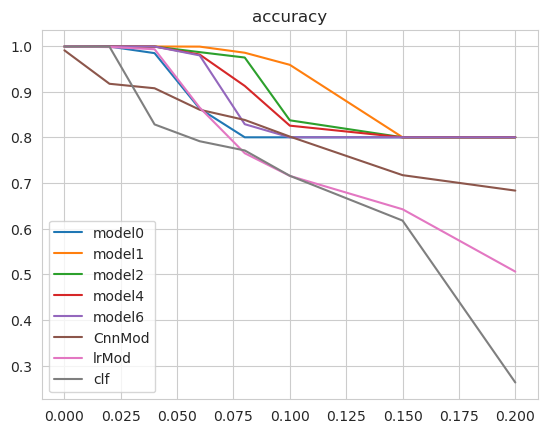

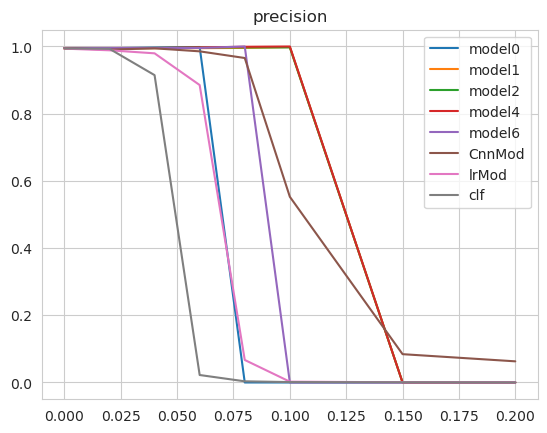

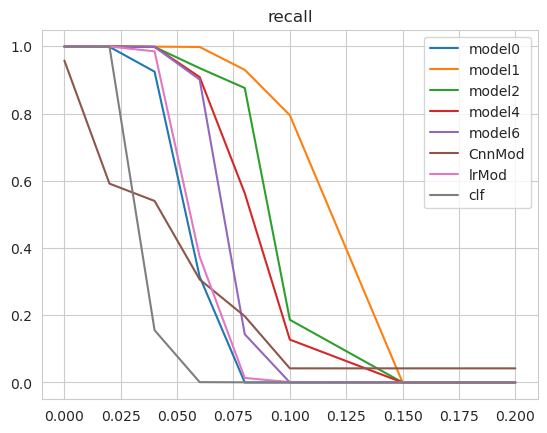

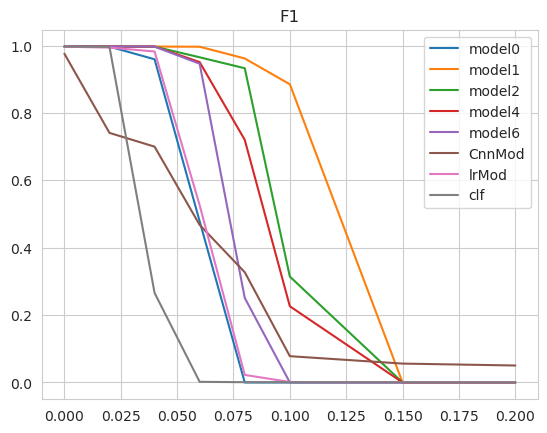

In [129]:
import matplotlib.pyplot as plt 
#from importlib import reload
#plt=reload(plt)

def getModNames():
    lst=[]
    for x in dicx:lst.append(x)
    return lst
def getXs():
    lst=[]
    for x in dicx:
        st=x;break
    for x in dicx[st]:
        if x!='ART':lst.append(x)
    return lst
    
def getART_info(name,perf):
    #print(name)
    
    lst=[]
    for x in dicx[name]:
        if x!='ART':
          lst.append(dicx[name][x][perf])
        else: tim=dicx[name][x]
    #print(perfs[perf],lst,tim)
    return lst

perfs=['ConfMat','accuracy','precision','recall','F1']
for j in range(1,5):
    hlst=[]
    for name in  dicx:
        xxx=getART_info(name,j)
        hlst.append(xxx)
    n= getModNames()
    y=hlst
    #print(n)
    x=getXs()
    #print(y)
    #print(x)
    for i in range(len(y)):
        plt.plot(x,y[i],label=n[i])
    plt.legend()
    st=perfs[j]

    plt.title(st)
    plt.show()
    

# Results

In [214]:
f = open("Results.csv", "w")
#f.write("Now the file has more content!")

fmtt='{:35s},{:6s},{:6s},{:6s},{:6s},{:8s},{:8s},{:8},  {:10s}'
fmt='{:35s},{:.4f},{:.4f},{:.4f},{:.4f},{:8.1f},{:8.1f},{:8},  {:10s}'
names=[]
for name in mmd:names.append(name)
st=fmtt.format('Description','Acc','Prec','Rec','F1','TrnTm','TstTm','TrnSet','Framework')
print(st)
f.write(st+'\n')
for name in names:
    model=mmd[name]
    perf=model['performance']
    tr_t=round(model['times'][0],1);ts_t=round(model['times'][1],1);
    #print(len(perf))
    if len(perf) >5: 
        perf=[round(perf[x],3) for x in [2,4,6,8]]
    else: perf=[round(perf[x],3) for x in range(1,len(perf))]
    st=fmt.format(model['description'],perf[0],perf[1],perf[2],perf[3],tr_t,ts_t,model['data'][0],model['framework'])
    print(st)
    f.write(st+'\n')
f.close()

#names


Description                        ,Acc   ,Prec  ,Rec   ,F1    ,TrnTm   ,TstTm   ,TrnSet  ,  Framework 
Radom Forest                       ,1.0000,0.9980,1.0000,0.9990,     8.1,     5.9,  100000,  sklearn   
Shallow ANN one hidden Layer       ,0.9990,0.9960,1.0000,0.9980,    20.2,     8.3, 1305090,  keras     
Shallow  ANN one layer & dropout   ,0.9990,0.9950,1.0000,0.9970,    27.9,     9.7, 1305090,  keras     
MLP two layers & dropout           ,0.9990,0.9970,0.9990,0.9980,    49.0,    11.0, 1305090,  keras     
Dense MLP 4 layers & dropout       ,0.9990,0.9980,0.9990,0.9980,    71.2,    13.2, 1305090,  keras     
Dense MLP 6 layers & dropout layers,0.9990,0.9980,0.9990,0.9980,   174.2,    20.6, 1305090,  keras     
CNN neural Network                 ,0.9900,0.9970,0.9550,0.9750,   504.5,     9.7,  100000,  keras     
Vanilla Logistic Regression        ,0.9990,0.9950,1.0000,0.9970,     2.0,     1.2,  100000,  sklearn   
Support Vector Machine             ,0.9990,0.9960,1.0000,0.9980,

In [199]:
mmd['model0']

{'performance': [[[548555, 635], [65, 142805]],
  0.9989885270063289,
  0.9955730619074178,
  0.9995450409463148,
  0.9975550976214592],
 'type': 'ANN',
 'data': (1305090, 78),
 'times': [20.208245515823364, 8.30284595489502],
 'description': 'Shallow ANN one hidden Layer',
 'framework': 'keras'}

# Analysing a single sample

In [ ]:
from random import randint
from art.estimators.classification import KerasClassifier,TensorFlowV2Classifier
mod=model
rand_idx = randint(0,y_test.shape[0])
rand_idx=1

label=y_test.tolist()[rand_idx]

sample=x_test[rand_idx:rand_idx+1]
label=y_test.tolist()[rand_idx]
#pred=mod(sample)
pred=predict(mod,sample)
print(sample,":",label,"->",pred)

import tensorflow as tf
##mod(sample).dtype
label
lab=[label]
lab=tf.cast([lab], tf.float32)
#print(mod(sample).dtype)
print(lab,lab.dtype)
classifier=KerasClassifier(mod)
MMD['clf']
#classifier(sample)

--------

# Stop here

In [ ]:
raise Exception("Quit Here")

In [ ]:
'''
from sklearn.decomposition import PCA

n_comp = range(2,34)
PCA_test_accuracies =[]
PCA_val_accuracies=[]
for i in n_comp:
    pca = PCA(n_components=i,random_state=0)
    pca_train = tf.convert_to_tensor(pca.fit_transform(Xtrain_scaled))
    pca_val = tf.convert_to_tensor(pca.transform(X_val_scaled))
    pca_test = tf.convert_to_tensor(pca.transform(X_test_scaled))
    pca_accuracies_dict, pca_models_dict,pca_models_train_acc,pca_models_test_acc,pca_models_valid_acc = Build_experment(pca_train, y_train_encoded, pca_val, y_val_encoded, pca_test, y_test_encoded, optimizer, n_of_hidden_layers=1, n_neurons=10, activation='relu', epochs=100, batch_size=512, n_of_models=5)

    PCA_test_accuracies.append(pca_accuracies_dict['AVG_test_acc'])
    PCA_val_accuracies.append(pca_accuracies_dict['AVG_valid_acc'])
'''
print()